Reference project - https://github.com/arseniyturin/dsc-2-final-project-online-ds-sp-000

Northwind Database Description - https://theaccessbuddy.wordpress.com/2011/07/03/northwind-database-explained/

In [1]:
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import inspect
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

In [3]:
from scipy import stats
import numpy as np
import itertools
import pandas as pd

In [4]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison


In [5]:
import datetime as dt
from datetime import date

In [6]:
engine = create_engine('sqlite:///Northwind_small.sqlite', echo=True)
Session = sessionmaker(bind=engine)
session = Session()

In [7]:
inspector = inspect(engine)

2019-04-04 12:59:25,130 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-04-04 12:59:25,131 INFO sqlalchemy.engine.base.Engine ()
2019-04-04 12:59:25,133 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-04-04 12:59:25,134 INFO sqlalchemy.engine.base.Engine ()


In [8]:
con = engine.connect()

In [4]:
print(inspector.get_table_names())

2019-03-30 13:40:18,191 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-03-30 13:40:18,192 INFO sqlalchemy.engine.base.Engine ()
['Category', 'Customer', 'CustomerCustomerDemo', 'CustomerDemographic', 'Employee', 'EmployeeTerritory', 'Order', 'OrderDetail', 'Product', 'Region', 'Shipper', 'Supplier', 'Territory']


In [5]:
table_names = ['Category', 'Customer', 'CustomerCustomerDemo', 'CustomerDemographic', 'Employee', 
               'EmployeeTerritory', 'Order', 'OrderDetail', 'Product', 'Region', 'Shipper', 'Supplier', 'Territory']

In [9]:
def col_names(table):
    name_list = []
    names = inspector.get_columns(table)
    for element in names:
        name_list.append(element.get('name'))
    return name_list
 

In [10]:
def make_df(table, cols):
    if cols == None:
        return pd.read_sql_query(f'SELECT * FROM {table}', engine)
    else:
        return pd.read_sql_query(f'SELECT {cols} FROM {table}', engine)

In [11]:
def join_2 (table1, table2, cols, on):
    if cols == None:
        return pd.read_sql_query(f"SELECT * FROM {table1} JOIN {table2} on {on}", engine)
    else:
        return pd.read_sql_query(f"SELECT {cols} FROM {table1} JOIN {table2} on {on}", engine)
    
def join_3 (table1, table2, table3, cols, on1, on2):
    if cols == None:
        return pd.read_sql_query(f"SELECT * FROM {table1} JOIN {table2} on {on1} JOIN {table3} on {on2}", engine)
    else:
        return pd.read_sql_query(f"SELECT {cols} FROM {table1} JOIN {table2} on {on1} JOIN {table3} on {on2}", engine)
    
def join_4 (table1, table2, table3, table4, cols, on1, on2, on3):
    if cols == None:
        return pd.read_sql_query(f"SELECT * FROM {table1} JOIN {table2} on {on1} JOIN {table3} on {on2} JOIN {table4} on {on3}", engine)
    else:
        return pd.read_sql_query(f"SELECT {cols} FROM {table1} JOIN {table2} on {on1} JOIN {table3} on {on2} JOIN {table4} on {on3}", engine)
    

In [26]:
def norm_check(series, name):
    ks_result = stats.kstest(series, 'norm', args=(series.mean(), series.std()))
    sw_result = stats.shapiro(series)
    print(f"""Normality Check for {name}: 
    Kolmogorov-Smirnov: {ks_result[1]}
    Shapiro-Wilks: {sw_result[1]}""")
    print(f"Variance: {series.var()}")
    fig, axes = plt.subplots(1,2, figsize=[12,6])
    sns.distplot(series, ax=axes[0])
    plt.title(name)
    stats.probplot(series, plot=axes[1])
    plt.show()

In [27]:
def variance_check(series1, series2, norm):
    if norm == 'yes':
        res = stats.levene(series1, series2)
        return res[1]
    else:
        res = stats.bartlett(series1, series2)
        return res[1]

In [28]:
def variance_check_multiple(combos, df, grouper, target, normal, cols):
    store_values = []
    for combo in combos:
        samp1 = df.loc[df[grouper] == combo[0]]
        samp2 = df.loc[df[grouper] == combo[1]]
        v = variance_check(samp1[target], samp2[target], normal)
        if v >= 0.05:
            r = 'EQUAL variance'
        elif v < 0.05:
            r = 'UNEQUAL variance'
        store_values.append([combo[0], combo[1], v, r])
    
    return pd.DataFrame(store_values, columns=cols)


In [29]:
def ks_test_2(sample1, sample2, name):
    results = stats.ks_2samp(sample1, sample2)
    return print(f"P-value for {name}: {results[1]}")

In [30]:
def ks_test2_revised(sample1, sample2):
    results = stats.ks_2samp(sample1, sample2)
    return results[1]

In [31]:
def non_parametric(series1, series2):
    np = []
    ks = stats.ks_2samp(series1, series2)
    mwu = stats.mannwhitneyu(series1, series2)
    kw = stats.kruskal(series1, series2)
    
    if ks[1]<0.05 or mwu[1]<0.05 or kw[1]<0.05:
        d = cohen_d(series1, series2)
    else:
        d = '--'
    
    np.append([ks[1], mwu[1], kw[1], d])
    
    return np

In [32]:
def cohen_d(series1, series2):

    # Compute the effect size (in the form of Cohen's d) for significant results.

    # series1: Series or NumPy array
    # series2: Series or NumPy array

    # returns a floating point number 

    diff_means = series1.mean() - series2.mean()

    n1, n2 = len(series1), len(series2)
    var1 = series1.var()
    var2 = series2.var()

    # Calculate the pooled threshold
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff_means / np.sqrt(pooled_var)
    
    return d

In [33]:
def stats_output(combos, df, grouper, target, cols):
    hold = []
    for combo in combos:
        samp1 = df.loc[df[grouper] == combo[0]]
        samp2 = df.loc[df[grouper] == combo[1]]
        
        nps = non_parametric(samp1[target], samp2[target])
        
        hold.append([combo[0], combo[1], nps[0][0], nps[0][1], nps[0][2], nps[0][3]])
        
    return pd.DataFrame(hold, columns=cols)

In [164]:
col_names('OrderDetail')

['Id', 'OrderId', 'ProductId', 'UnitPrice', 'Quantity', 'Discount']

In [165]:
col_names('Product')

['Id',
 'ProductName',
 'SupplierId',
 'CategoryId',
 'QuantityPerUnit',
 'UnitPrice',
 'UnitsInStock',
 'UnitsOnOrder',
 'ReorderLevel',
 'Discontinued']

In [166]:
col_names('Order')

['Id',
 'CustomerId',
 'EmployeeId',
 'OrderDate',
 'RequiredDate',
 'ShippedDate',
 'ShipVia',
 'Freight',
 'ShipName',
 'ShipAddress',
 'ShipCity',
 'ShipRegion',
 'ShipPostalCode',
 'ShipCountry']

In [10]:
q = 'SELECT * from OrderDetail o join Product p on o.ProductId = p.Id GROUP BY o.Discount'
df = pd.read_sql_query(q, engine)
df.head()

2019-04-01 08:59:06,224 INFO sqlalchemy.engine.base.Engine SELECT * from OrderDetail o join Product p on o.ProductId = p.Id GROUP BY o.Discount
2019-04-01 08:59:06,225 INFO sqlalchemy.engine.base.Engine ()


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,11077/77,11077,77,13.00,2,0.00,77,Original Frankfurter grüne Soße,12,2,12 boxes,13.00,32,0,15,0
1,11077/73,11077,73,15.00,2,0.01,73,Röd Kaviar,17,8,24 - 150 g jars,15.00,101,0,5,0
2,11077/46,11077,46,12.00,3,0.02,46,Spegesild,21,8,4 - 450 g glasses,12.00,95,0,0,0
3,11077/64,11077,64,33.25,2,0.03,64,Wimmers gute Semmelknödel,12,5,20 bags x 4 pieces,33.25,22,80,30,0
4,11077/20,11077,20,81.00,1,0.04,20,Sir Rodney's Marmalade,8,3,30 gift boxes,81.00,40,0,0,0


In [12]:
dc = df.loc[df.Discontinued == 1]
dc

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued


In [23]:
df.drop('Id', axis=1, inplace=True) #This drops both 'Id' columns. May not be terrible though because one Id column
# was a combo of OrderId and ProductId and the other Id column was just the ProductId
df.head()

,OrderId,ProductId,UnitPrice,Quantity,Discount,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,10248,11,14.0,12,0.0,Queso Cabrales,5,4,1 kg pkg.,21.00,22,30,30,0
1,10248,42,9.8,10,0.0,Singaporean Hokkien Fried Mee,20,5,32 - 1 kg pkgs.,14.00,26,0,0,1
2,10248,72,34.8,5,0.0,Mozzarella di Giovanni,14,4,24 - 200 g pkgs.,34.80,14,0,0,0
3,10249,14,18.6,9,0.0,Tofu,6,7,40 - 100 g pkgs.,23.25,35,0,0,0
4,10249,51,42.4,40,0.0,Manjimup Dried Apples,24,7,50 - 300 g pkgs.,53.00,20,0,10,0


In [33]:
df = df.reindex()

In [54]:
groupOrder = df.groupby(['OrderId'])['ProductId', 'Quantity', 'Discount']

In [15]:
df_product = make_df('Product', cols=None)
df_product.head()
df_product.shape

2019-04-01 09:01:04,465 INFO sqlalchemy.engine.base.Engine SELECT * FROM Product
2019-04-01 09:01:04,466 INFO sqlalchemy.engine.base.Engine ()


(77, 10)

In [17]:
df_DC = df_product.loc[df_product.Discontinued == 1]
df_DC

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
4,5,Chef Anton's Gumbo Mix,2,2,36 boxes,21.35,0,0,0,1
8,9,Mishi Kobe Niku,4,6,18 - 500 g pkgs.,97.00,29,0,0,1
16,17,Alice Mutton,7,6,20 - 1 kg tins,39.00,0,0,0,1
23,24,Guaraná Fantástica,10,1,12 - 355 ml cans,4.50,20,0,0,1
27,28,Rössle Sauerkraut,12,7,25 - 825 g cans,45.60,26,0,0,1
28,29,Thüringer Rostbratwurst,12,6,50 bags x 30 sausgs.,123.79,0,0,0,1
41,42,Singaporean Hokkien Fried Mee,20,5,32 - 1 kg pkgs.,14.00,26,0,0,1
52,53,Perth Pasties,24,6,48 pieces,32.80,0,0,0,1


In [18]:
value_dc = sum(df_DC.UnitsInStock*df_DC.UnitPrice)
value_dc

4452.6

### Is there a difference in cost between shipping companies?

In [20]:
orders = make_df('[Order]', cols=None)
orders.head()

# orders = pd.read_sql_query('SELECT * FROM [Order]', engine)
# orders.head()
# #test1.shape

2019-04-04 13:02:23,172 INFO sqlalchemy.engine.base.Engine SELECT * FROM [Order]
2019-04-04 13:02:23,173 INFO sqlalchemy.engine.base.Engine ()


,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


In [21]:
df_ship = make_df('Shipper', cols=None)
df_ship.head()

2019-04-01 09:06:02,261 INFO sqlalchemy.engine.base.Engine SELECT * FROM Shipper
2019-04-01 09:06:02,262 INFO sqlalchemy.engine.base.Engine ()


,Id,CompanyName,Phone
0,1,Speedy Express,(503) 555-9831
1,2,United Package,(503) 555-3199
2,3,Federal Shipping,(503) 555-9931


In [32]:
group_region = orders.groupby(['ShipVia','ShipRegion'])['Freight'].agg(['mean', 'median', 'std', 'sum', 'count'])
group_region

mean   median         std      sum  count
ShipVia ShipRegion                                                      
1       British Isles     66.572667   47.300   57.485208   998.59     15
        Central America   44.077500   45.675   22.039967   176.31      4
        Eastern Europe     8.720000    8.720         NaN     8.72      1
        North America     73.680571   52.520   69.208836  2578.82     35
        Northern Europe   68.477000   51.730   81.144013  1369.54     20
        Scandinavia       32.375556   16.720   45.928972   291.38      9
        South America     47.098679   33.050   48.288939  2496.23     53
        Southern Europe   28.228000   13.950   35.660165   705.70     25
        Western Europe    86.897011   47.840   96.172905  7560.04     87
2       British Isles     97.627813   40.000  149.920104  3124.09     32
        Central America   52.813000   30.540   63.966042   528.13     10
        Eastern Europe    50.480000   50.480   42.666823   100.96      2
        North America    112.201311   44.720  182.371436  6844.28     61
        Northern Europe  117.591000  106.090   96.011426  2351.82     20
        Scandinavia       69.230000   58.590   63.332403   623.07      9
        South America     70.300345   46.155  123.727933  4077.42     58
        Southern Europe   51.249524   28.710   56.700520  1076.24     21
        Western Europe    84.237522   43.300  140.528131  9518.84    113
3       British Isles     56.672500   31.025   68.775724  1586.83     28
        Central America   29.881429   19.870   27.147728   418.34     14
        Eastern Europe    16.515000   17.915   10.434438    66.06      4
        North America    116.897857   54.020  151.390535  6546.28     56
        Northern Europe   60.828667   27.360   66.825969   912.43     15
        Scandinavia       27.194000   27.450   21.602563   271.94     10
        South America     48.244118   30.645   53.621585  1640.30     34
        Southern Europe   32.662222   17.455   33.601001   587.92     18
        Western Europe   111.610658   68.895  151.138614  8482.41     76

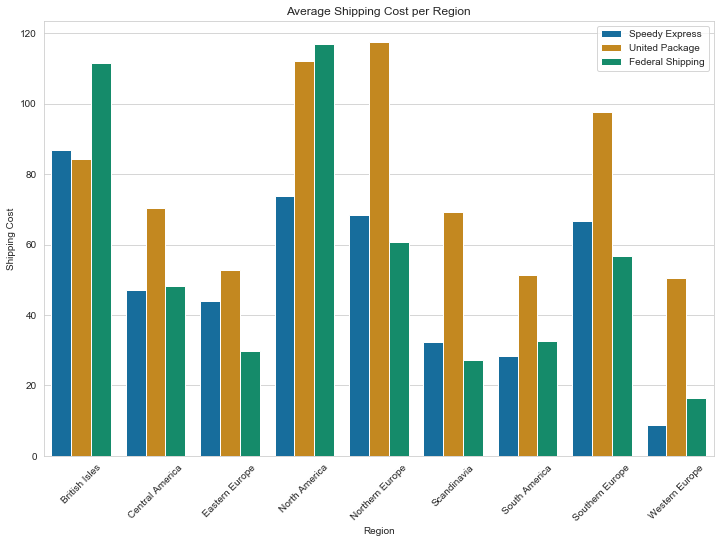

In [21]:
from numpy import median
fig = plt.figure(figsize=[12,8])
sns.barplot(x='ShipRegion', y='Freight', data=orders, hue='ShipVia', ci=0, palette='colorblind')
plt.xticks(np.arange(9), ('British Isles', 'Central America', 'Eastern Europe', 'North America', 'Northern Europe', 
                         'Scandinavia', 'South America', 'Southern Europe', 'Western Europe'), rotation=45)
plt.ylabel('Shipping Cost')
plt.xlabel('Region')
plt.title('Average Shipping Cost per Region')
L=plt.legend()
L.get_texts()[0].set_text('Speedy Express')
L.get_texts()[1].set_text('United Package')
L.get_texts()[2].set_text('Federal Shipping')
plt.show()

source: https://towardsdatascience.com/hypothesis-testing-in-the-northwind-dataset-using-anova-db3ab16b5eba

In [35]:
# Group Scandinavia with Northern Europe, Eastern Europe with Southern Europe, and Central America with South America
# to help equalize the sample sizes between the regions for testing

orders_region_grouped = orders.copy()

orders_region_grouped.loc[(orders_region_grouped.ShipRegion == 'Northern Europe') | 
                          (orders_region_grouped.ShipRegion == 'Scandinavia'),
                          'ShipRegion'] = 'Northern Europe/Scandinavia'
orders_region_grouped.loc[(orders_region_grouped.ShipRegion == 'Eastern Europe') | 
                          (orders_region_grouped.ShipRegion == 'Southern Europe'), 
                          'ShipRegion'] = 'Eastern/Southern Europe'
orders_region_grouped.loc[(orders_region_grouped.ShipRegion == 'Central America') | 
                          (orders_region_grouped.ShipRegion == 'South America'), 
                          'ShipRegion'] = 'Central/South America'

orders_region_grouped.head()



,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,Central/South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


In [36]:
orders_region_grouped.groupby(['ShipVia','ShipRegion'])['Freight'].agg(['mean', 'median', 'std', 'sum', 'count'])


mean  median         std      sum  \
ShipVia ShipRegion                                                             
1       British Isles                 66.572667  47.300   57.485208   998.59   
        Central/South America         46.886667  34.760   46.817647  2672.54   
        Eastern/Southern Europe       27.477692  13.320   35.148521   714.42   
        North America                 73.680571  52.520   69.208836  2578.82   
        Northern Europe/Scandinavia   57.273103  24.390   73.209086  1660.92   
        Western Europe                86.897011  47.840   96.172905  7560.04   
2       British Isles                 97.627813  40.000  149.920104  3124.09   
        Central/South America         67.728676  42.180  116.671725  4605.55   
        Eastern/Southern Europe       51.182609  28.710   54.822241  1177.20   
        North America                112.201311  44.720  182.371436  6844.28   
        Northern Europe/Scandinavia  102.582414  92.690   88.992423  2974.89   
        Western Europe                84.237522  43.300  140.528131  9518.84   
3       British Isles                 56.672500  31.025   68.775724  1586.83   
        Central/South America         42.888333  27.140   47.893683  2058.64   
        Eastern/Southern Europe       29.726364  17.455   31.147425   653.98   
        North America                116.897857  54.020  151.390535  6546.28   
        Northern Europe/Scandinavia   47.374800  27.360   55.342766  1184.37   
        Western Europe               111.610658  68.895  151.138614  8482.41   

                                     count  
ShipVia ShipRegion                          
1       British Isles                   15  
        Central/South America           57  
        Eastern/Southern Europe         26  
        North America                   35  
        Northern Europe/Scandinavia     29  
        Western Europe                  87  
2       British Isles                   32  
        Central/South America           68  
        Eastern/Southern Europe         23  
        North America                   61  
        Northern Europe/Scandinavia     29  
        Western Europe                 113  
3       British Isles                   28  
        Central/South America           48  
        Eastern/Southern Europe         22  
        North America                   56  
        Northern Europe/Scandinavia     25  
        Western Europe                  76

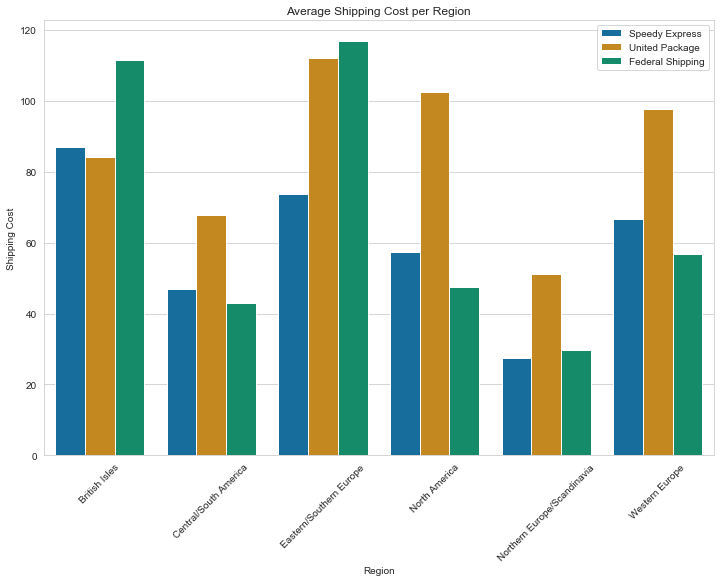

In [36]:
fig = plt.figure(figsize=[12,8])
sns.barplot(x='ShipRegion', y='Freight', data=orders_region_grouped, hue='ShipVia', ci=0, palette='colorblind')
plt.xticks(np.arange(6), ('British Isles', 'Central/South America', 'Eastern/Southern Europe', 'North America', 
                          'Northern Europe/Scandinavia', 'Western Europe'), 
           rotation=45)
plt.ylabel('Shipping Cost')
plt.xlabel('Region')
plt.title('Average Shipping Cost per Region')
L=plt.legend()
L.get_texts()[0].set_text('Speedy Express')
L.get_texts()[1].set_text('United Package')
L.get_texts()[2].set_text('Federal Shipping')
plt.show()

In [37]:
ship1 = orders_region_grouped.loc[orders_region_grouped.ShipVia == 1]
print(ship1.shape)
ship2 = orders_region_grouped.loc[orders_region_grouped.ShipVia == 2]
print(ship2.shape)
ship3 = orders_region_grouped.loc[orders_region_grouped.ShipVia == 3]
print(ship3.shape)

(249, 14)
(326, 14)
(255, 14)


Normality Check for Speedy Express: 
    Kolmogorov-Smirnov: 9.528365652045068e-09
    Shapiro-Wilks: 2.024363869389547e-18
Variance: 5684.192986542946


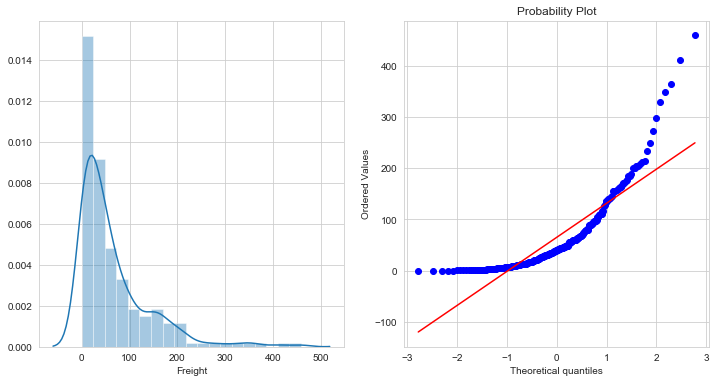

Normality Check for United Package: 
    Kolmogorov-Smirnov: 0.0
    Shapiro-Wilks: 2.95463730560449e-27
Variance: 19104.564505122224


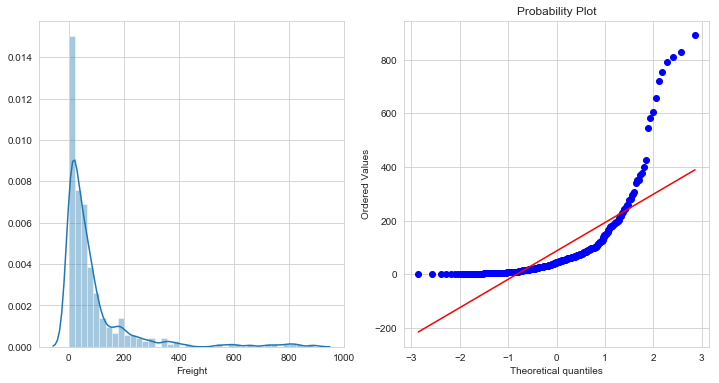

Normality Check for Federal Shipping: 
    Kolmogorov-Smirnov: 1.1324274851176597e-14
    Shapiro-Wilks: 3.371958171463351e-23
Variance: 14247.488617020224


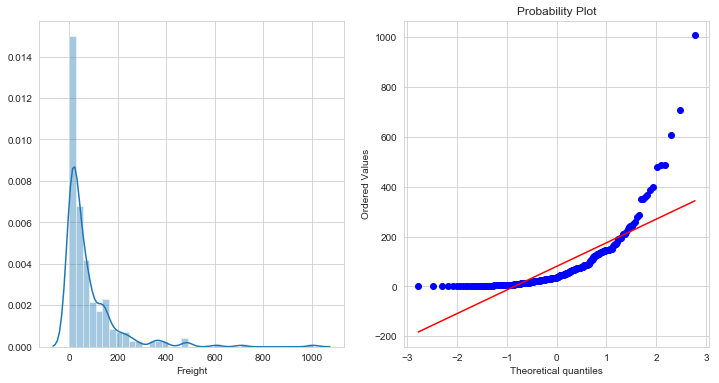

In [38]:
norm_check(ship1.Freight, 'Speedy Express')
norm_check(ship2.Freight, 'United Package')
norm_check(ship3.Freight, 'Federal Shipping')

In [39]:
ship_combos = list(itertools.combinations(orders_region_grouped.ShipVia.unique(), 2))

In [40]:
columns = ['ShipCompany1', 'ShipCompany2', 'Variance_Test_p', 'Result']
variance_check_multiple(ship_combos, orders_region_grouped, 'ShipVia', 'Freight', 'no', columns)

,ShipCompany1,ShipCompany2,Variance_Test_p,Result
0,3,1,9.565535e-13,UNEQUAL variance
1,3,2,1.406535e-02,UNEQUAL variance
2,1,2,5.840075e-22,UNEQUAL variance


In [58]:
def stats_output(combos, df, grouper, target, cols):
    hold = []
    for combo in combos:
        samp1 = df.loc[df[grouper] == combo[0]]
        samp2 = df.loc[df[grouper] == combo[1]]
        
        nps = non_parametric(samp1[target], samp2[target])
        
        hold.append([combo[0], combo[1], nps[0][0], nps[0][1], nps[0][2], nps[0][3]])
        
    return pd.DataFrame(hold, columns=cols)

In [41]:
columns = ['Company1', 'Company2', 'Kolmogorov_Smirnov_p', 'Mann_WhitneyU_p', 'KW_p', 'Effect_Size']
stats_output(ship_combos, orders_region_grouped, 'ShipVia', 'Freight', columns)

,Company1,Company2,Kolmogorov_Smirnov_p,Mann_WhitneyU_p,KW_p,Effect_Size
0,3,1,0.766395,0.360333,0.720437,--
1,3,2,0.910420,0.379789,0.759388,--
2,1,2,0.697865,0.232999,0.465842,--


In [31]:
# cost_ship = []

# for combo in ship_combos:
#     samp1 = orders_region_grouped.loc[orders_region_grouped.ShipVia == combo[0]]
#     samp2 = orders_region_grouped.loc[orders_region_grouped.ShipVia == combo[1]]
    
#     nps = non_parametric(samp1.Freight, samp2.Freight)
    
#     cost_ship.append([combo[0], combo[1], nps[0][0], nps[0][1], nps[0][2], nps[0][3]])
    
# stats_cost_ship = pd.DataFrame(cost_ship, columns=['Company1', 'Company2', 'KS_p', 'MWU_p', 'KW_p', 'Effect_Size'])
# stats_cost_ship

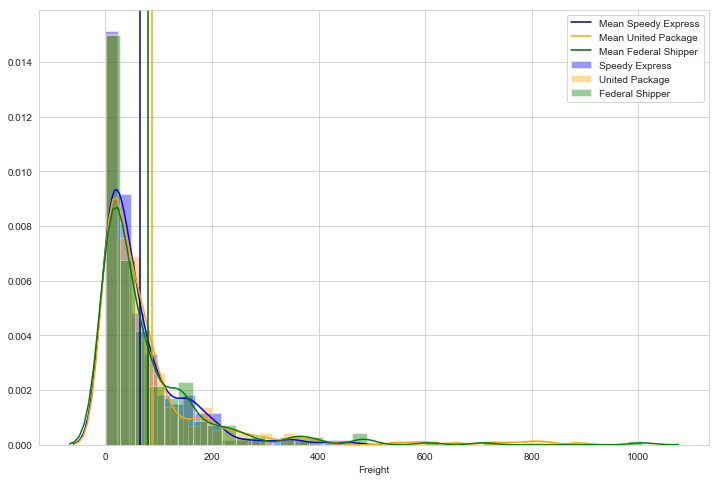

In [42]:
fig = plt.figure(figsize=[12,8])
sns.distplot(ship1.Freight, color='blue', label='Speedy Express')
plt.axvline(x=ship1.Freight.mean(), color='darkblue', label='Mean Speedy Express')
sns.distplot(ship2.Freight, color='orange', label='United Package')
plt.axvline(x=ship2.Freight.mean(), color='orange', label='Mean United Package')
sns.distplot(ship3.Freight, color='green', label='Federal Shipper')
plt.axvline(x=ship3.Freight.mean(), color='darkgreen', label='Mean Federal Shipper')
plt.legend()
plt.show()

## Summary for comparison of shipping costs between the three shipping companies:
A two-sample KS was performed to evaluate the differences in frieght (shipping cost) between the three companies because the distributions of the frieght costs per company (shown above) are not normal and have unequal variences. THe KS tests determined that there is no significant difference of the freight costs between the three companies. Further evaluations should be performed to determine if the freight costs differ by region between the three companies.

## Is there a difference in the shipping cost per region for the three shipping companies?

In [242]:
ship1.ShipRegion.unique()

array(['Western Europe', 'North America', 'Northern Europe/Scandinavia',
       'Eastern/Southern Europe', 'Central/South America',
       'British Isles'], dtype=object)

In [43]:
# Subsample Speedy Express orders by region

we1 = ship1.loc[ship1.ShipRegion == 'Western Europe']
na1 = ship1.loc[ship1.ShipRegion == 'North America']
nes1 = ship1.loc[ship1.ShipRegion == 'Northern Europe/Scandinavia']
ese1 = ship1.loc[ship1.ShipRegion == 'Eastern/Southern Europe']
csa1 = ship1.loc[ship1.ShipRegion == 'Central/South America']
bi1 = ship1.loc[ship1.ShipRegion == 'British Isles']

In [44]:
# Subsample United Package orders by region

we2 = ship2.loc[ship2.ShipRegion == 'Western Europe']
na2 = ship2.loc[ship2.ShipRegion == 'North America']
nes2 = ship2.loc[ship2.ShipRegion == 'Northern Europe/Scandinavia']
ese2 = ship2.loc[ship2.ShipRegion == 'Eastern/Southern Europe']
csa2 = ship2.loc[ship2.ShipRegion == 'Central/South America']
bi2 = ship2.loc[ship2.ShipRegion == 'British Isles']

In [45]:
# Subsample Federal Shipper orders by region

we3 = ship3.loc[ship3.ShipRegion == 'Western Europe']
na3 = ship3.loc[ship3.ShipRegion == 'North America']
nes3 = ship3.loc[ship3.ShipRegion == 'Northern Europe/Scandinavia']
ese3 = ship3.loc[ship3.ShipRegion == 'Eastern/Southern Europe']
csa3 = ship3.loc[ship3.ShipRegion == 'Central/South America']
bi3 = ship3.loc[ship3.ShipRegion == 'British Isles']

The three cells below check for normality in freight costs between the regions for the three shipping companies. Commented out to save space.

In [50]:
# Check normality of the distribution of shipping costs per region for Speedy Express

# for region in ship1.ShipRegion.unique():
#     reg = ship1.loc[ship1.ShipRegion == region]
#     norm_check(reg.Freight, region)

In [39]:
# Check normality of the distribution of shipping costs per region for United Package

# for region in ship2.ShipRegion.unique():
#     reg = ship2.loc[ship2.ShipRegion == region]
#     norm_check(reg.Freight, region)


In [42]:
# Check normality of the distribution of shipping costs per region for Federal Shipper

# for region in ship3.ShipRegion.unique():
#     reg = ship3.loc[ship3.ShipRegion == region]
#     norm_check(reg.Freight, region)


In [46]:
#import itertools

region_combos = list(itertools.combinations(ship1.ShipRegion.unique(), 2))
#combos

The three cells below check for equal variance between the freight costs of the possible combination of regions for each shipping company. Commented out to save space.

In [48]:
# Check for equal variance between the regions for Speedy Express

# columns = ['Region1', 'Region2', 'Variance_Test_p', 'Result']
# variance_check_multiple(region_combos, ship1, 'ShipRegion', 'Freight', 'no', columns)


In [48]:
# Check for equal variance between the regions for United Package

# columns = ['Region1', 'Region2', 'Variance_Test_p', 'Result']
# variance_check_multiple(region_combos, ship2, 'ShipRegion', 'Freight', 'no', columns)


In [51]:
# Check for eaqual variance between the regions for Federal Package

# columns = ['Region1', 'Region2', 'Variance_Test_p', 'Result']
# variance_check_multiple(region_combos, ship3, 'ShipRegion', 'Freight', 'no', columns)


In [51]:
columns = ['Region1', 'Region2', 'Kolmogorov-Smirnov_p', 'Mann_WhitneyU_p', 'KW_p', 'Effect_Size']
stats_output(region_combos, ship1, 'ShipRegion', 'Freight', columns)

,Region1,Region2,Kolmogorov-Smirnov_p,Mann_WhitneyU_p,KW_p,Effect_Size
0,Western Europe,North America,0.956282,0.384249,0.766337,--
1,Western Europe,Northern Europe/Scandinavia,0.135320,0.037111,0.073707,0.32562
2,Western Europe,Eastern/Southern Europe,0.001830,0.000096,0.000190,0.690486
3,Western Europe,Central/South America,0.059266,0.008522,0.016951,0.497967
4,Western Europe,British Isles,0.886313,0.356252,0.708985,--
5,North America,Northern Europe/Scandinavia,0.483406,0.097710,0.193104,--
6,North America,Eastern/Southern Europe,0.032194,0.001151,0.002248,0.807371
7,North America,Central/South America,0.128301,0.053868,0.106859,--
8,North America,British Isles,0.986586,0.483114,0.957791,--
9,Northern Europe/Scandinavia,Eastern/Southern Europe,0.237220,0.063543,0.124999,--


In [52]:
columns = ['Region1', 'Region2', 'Kolmogorov-Smirnov_p', 'Mann_WhitneyU_p', 'KW_p', 'Effect_Size']
stats_output(region_combos, ship2, 'ShipRegion', 'Freight', columns)

,Region1,Region2,Kolmogorov-Smirnov_p,Mann_WhitneyU_p,KW_p,Effect_Size
0,Western Europe,North America,0.913603,0.368471,0.735753,--
1,Western Europe,Northern Europe/Scandinavia,0.045161,0.034827,0.069266,-0.139343
2,Western Europe,Eastern/Southern Europe,0.419356,0.242106,0.482401,--
3,Western Europe,Central/South America,0.874467,0.286415,0.571834,--
4,Western Europe,British Isles,0.915868,0.457287,0.912683,--
5,North America,Northern Europe/Scandinavia,0.091319,0.113381,0.225107,--
6,North America,Eastern/Southern Europe,0.589427,0.175436,0.348288,--
7,North America,Central/South America,0.590687,0.174534,0.347856,--
8,North America,British Isles,0.913274,0.418310,0.833463,--
9,Northern Europe/Scandinavia,Eastern/Southern Europe,0.074968,0.028868,0.056532,0.678072


In [53]:
columns = ['Region1', 'Region2', 'Kolmogorov-Smirnov_p', 'Mann_WhitneyU_p', 'KW_p', 'Effect_Size']
stats_output(region_combos, ship3, 'ShipRegion', 'Freight', columns)

,Region1,Region2,Kolmogorov-Smirnov_p,Mann_WhitneyU_p,KW_p,Effect_Size
0,Western Europe,North America,0.711463,0.420628,0.839456,--
1,Western Europe,Northern Europe/Scandinavia,0.027325,0.006521,0.012898,0.479495
2,Western Europe,Eastern/Southern Europe,0.003280,0.000183,0.000360,0.611474
3,Western Europe,Central/South America,0.002812,0.000416,0.000824,0.563215
4,Western Europe,British Isles,0.071795,0.020994,0.041620,0.409868
5,North America,Northern Europe/Scandinavia,0.037944,0.020187,0.039877,0.536532
6,North America,Eastern/Southern Europe,0.006480,0.001195,0.002347,0.673981
7,North America,Central/South America,0.011809,0.002765,0.005474,0.639351
8,North America,British Isles,0.165215,0.053880,0.106726,--
9,Northern Europe/Scandinavia,Eastern/Southern Europe,0.444281,0.131505,0.258491,--


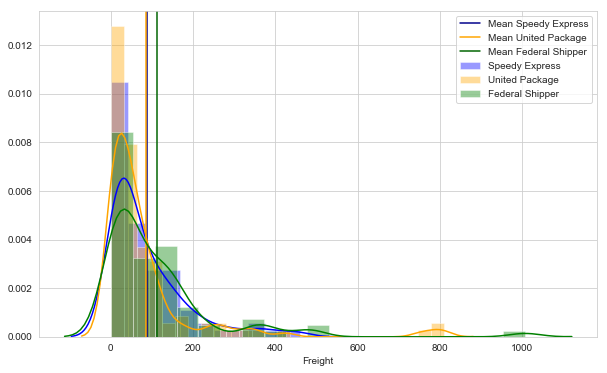

In [53]:
fig = plt.figure(figsize=[10,6])
sns.distplot(we1.Freight, color='blue', label='Speedy Express')
plt.axvline(we1.Freight.mean(), color='darkblue', label='Mean Speedy Express')
sns.distplot(we2.Freight, color='orange', label='United Package')
plt.axvline(we2.Freight.mean(), color='orange', label='Mean United Package')
sns.distplot(we3.Freight, color='green', label = 'Federal Shipper')
plt.axvline(we3.Freight.mean(), color='darkgreen', label='Mean Federal Shipper')
plt.legend()
plt.show()

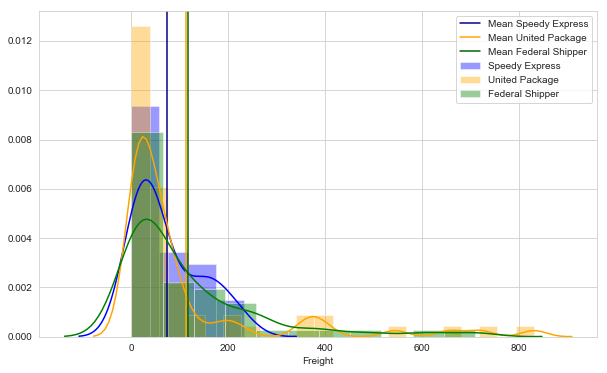

In [54]:
fig = plt.figure(figsize=[10,6])
sns.distplot(na1.Freight, color='blue', label='Speedy Express')
plt.axvline(na1.Freight.mean(), color='darkblue', label='Mean Speedy Express')
sns.distplot(na2.Freight, color='orange', label='United Package')
plt.axvline(na2.Freight.mean(), color='orange', label='Mean United Package')
sns.distplot(na3.Freight, color='green', label = 'Federal Shipper')
plt.axvline(na3.Freight.mean(), color='darkgreen', label='Mean Federal Shipper')
plt.legend()
plt.show()

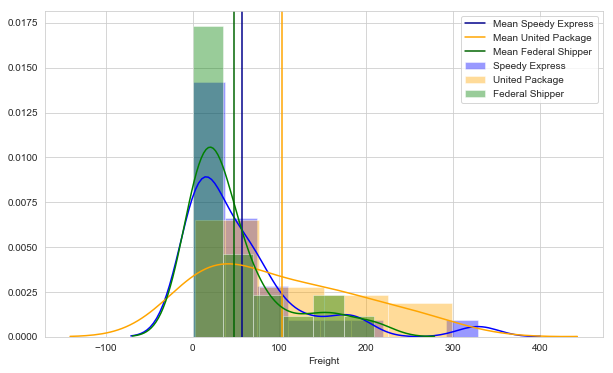

In [55]:
fig = plt.figure(figsize=[10,6])
sns.distplot(nes1.Freight, color='blue', label='Speedy Express')
plt.axvline(nes1.Freight.mean(), color='darkblue', label='Mean Speedy Express')
sns.distplot(nes2.Freight, color='orange', label='United Package')
plt.axvline(nes2.Freight.mean(), color='orange', label='Mean United Package')
sns.distplot(nes3.Freight, color='green', label = 'Federal Shipper')
plt.axvline(nes3.Freight.mean(), color='darkgreen', label='Mean Federal Shipper')
plt.legend()
plt.show()

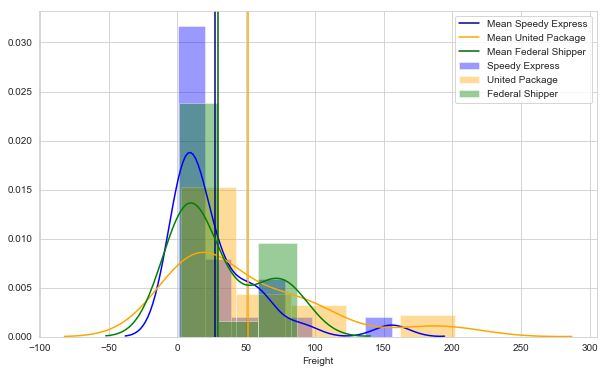

In [56]:
fig = plt.figure(figsize=[10,6])
sns.distplot(ese1.Freight, color='blue', label='Speedy Express')
plt.axvline(ese1.Freight.mean(), color='darkblue', label='Mean Speedy Express')
sns.distplot(ese2.Freight, color='orange', label='United Package')
plt.axvline(ese2.Freight.mean(), color='orange', label='Mean United Package')
sns.distplot(ese3.Freight, color='green', label = 'Federal Shipper')
plt.axvline(ese3.Freight.mean(), color='darkgreen', label='Mean Federal Shipper')
plt.legend()
plt.show()

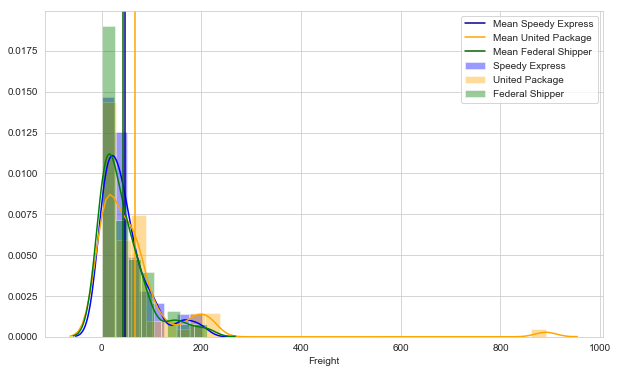

In [57]:
fig = plt.figure(figsize=[10,6])
sns.distplot(csa1.Freight, color='blue', label='Speedy Express')
plt.axvline(csa1.Freight.mean(), color='darkblue', label='Mean Speedy Express')
sns.distplot(csa2.Freight, color='orange', label='United Package')
plt.axvline(csa2.Freight.mean(), color='orange', label='Mean United Package')
sns.distplot(csa3.Freight, color='green', label = 'Federal Shipper')
plt.axvline(csa3.Freight.mean(), color='darkgreen', label='Mean Federal Shipper')
plt.legend()
plt.show()

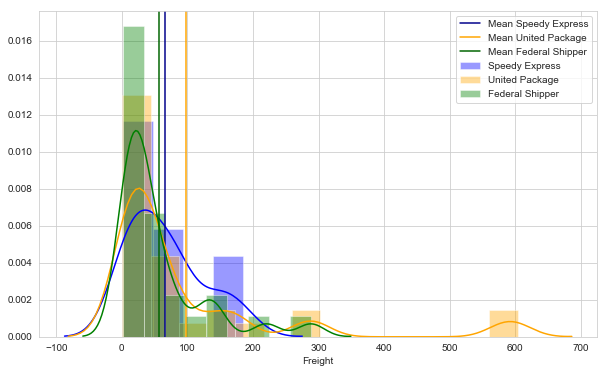

In [58]:
fig = plt.figure(figsize=[10,6])
sns.distplot(bi1.Freight, color='blue', label='Speedy Express')
plt.axvline(bi1.Freight.mean(), color='darkblue', label='Mean Speedy Express')
sns.distplot(bi2.Freight, color='orange', label='United Package')
plt.axvline(bi2.Freight.mean(), color='orange', label='Mean United Package')
sns.distplot(bi3.Freight, color='green', label = 'Federal Shipper')
plt.axvline(bi3.Freight.mean(), color='darkgreen', label='Mean Federal Shipper')
plt.legend()
plt.show()

In [309]:
# fig, axes =plt.subplots(1,3)
# sns.distplot(we1.Freight, color='blue', label='Speedy Express', ax=axes[0])
# plt.axvline(we1.Freight.mean(), color='darkblue', label='Mean Speedy Express')
# sns.distplot(we2.Freight, color='orange', label='United Package', ax=axes[1])
# plt.axvline(we2.Freight.mean(), color='orange', label='Mean United Package')
# sns.distplot(we3.Freight, color='green', label = 'Federal Shipper', ax=axes[2])
# plt.axvline(we3.Freight.mean(), color='darkgreen', label='Mean Federal Shipper')
# plt.legend()

# sns.distplot(na1.Freight, color='blue', label='Speedy Express')
# plt.axvline(na1.Freight.mean(), color='darkblue', label='Mean Speedy Express')
# sns.distplot(na2.Freight, color='orange', label='United Package')
# plt.axvline(na2.Freight.mean(), color='orange', label='Mean United Package')
# sns.distplot(na3.Freight, color='green', label = 'Federal Shipper')
# plt.axvline(na3.Freight.mean(), color='darkgreen', label='Mean Federal Shipper')
# plt.legend()
# plt.show()


In [229]:
# region_dummies = pd.get_dummies(test1.ShipRegion)
# test2 = pd.concat([test1, region_dummies], axis=1)
# test2.head()

In [241]:
# ship1['British_Isles'] = np.where((ship1.ShipRegion == 'British Isles'), 1, 0)
# ship1['Cen_Sou_America'] = np.where((ship1.ShipRegion == 'Central/South America'), 1, 0)
# ship1['East_South_Europe'] = np.where((ship1.ShipRegion == 'Eastern/Southern Europe'), 1, 0)
# ship1['North_America'] = np.where((ship1.ShipRegion == 'North America'), 1, 0)
# ship1['North_Europe_Scand'] = np.where((ship1.ShipRegion == 'Northern Europe/Scandinavia'), 1, 0)
# #ship1['South_America'] = np.where((ship1.ShipRegion == 'South America'), 1, 0)
# ship1['Western_Europe'] = np.where((ship1.ShipRegion == 'Western Europe'), 1, 0)
# ship1.head()

In [ ]:
#log_od['No_Discount'] = np.where((log_od.Discount_Median == 0.0), 1, 0)

In [55]:
#Is there a difference in shipping costs per region for speedy express

# formula = 'Freight ~ ShipRegion'
# lm = ols(formula, ship1).fit()
# table = sm.stats.anova_lm(lm, typ=2)
# print(table)

In [74]:
# ship1['British_Isles'] = np.where((ship1.ShipRegion == 'British Isles'), 1, 0)
# ship1['Cen_Sou_America'] = np.where((ship1.ShipRegion == 'Central/South America'), 1, 0)
# ship1['East_South_Europe'] = np.where((ship1.ShipRegion == 'Eastern/Southern Europe'), 1, 0)
# ship1['North_America'] = np.where((ship1.ShipRegion == 'North America'), 1, 0)
# ship1['North_Europe_Scand'] = np.where((ship1.ShipRegion == 'Northern Europe/Scandinavia'), 1, 0)
#         #ship1['South_America'] = np.where((ship1.ShipRegion == 'South America'), 1, 0)
# ship1['Western_Europe'] = np.where((ship1.ShipRegion == 'Western Europe'), 1, 0)
# ship1.head()

In [56]:
#Which regions significantly affect shipping cost for speedy express

# formula = 'Freight ~ British_Isles + Cen_Sou_America + East_South_Europe + North_America + North_Europe_Scand + Western_Europe'
# lm = ols(formula, ship1).fit()
# table = sm.stats.anova_lm(lm, typ=2)
# print(table)

In [57]:
#Is there a difference in shipping costs per region for united package

# formula = 'Freight ~ ShipRegion'
# lm = ols(formula, ship2).fit()
# table = sm.stats.anova_lm(lm, typ=2)
# print(table)

In [58]:
#Is there a difference in shipping costs per region for Federal Shipper

# formula = 'Freight ~ ShipRegion'
# lm = ols(formula, ship3).fit()
# table = sm.stats.anova_lm(lm, typ=2)
# print(table)

In [90]:
# ship3['British_Isles'] = np.where((ship3.ShipRegion == 'British Isles'), 1, 0)
# ship3['Cen_Sou_America'] = np.where((ship3.ShipRegion == 'Central/South America'), 1, 0)
# ship3['East_South_Europe'] = np.where((ship3.ShipRegion == 'Eastern/Southern Europe'), 1, 0)
# ship3['North_America'] = np.where((ship3.ShipRegion == 'North America'), 1, 0)
# ship3['North_Europe_Scand'] = np.where((ship3.ShipRegion == 'Northern Europe/Scandinavia'), 1, 0)
# ship3['South_America'] = np.where((ship3.ShipRegion == 'South America'), 1, 0)
# ship3['Western_Europe'] = np.where((ship3.ShipRegion == 'Western Europe'), 1, 0)
# ship3.head()

In [54]:
#Which regions significantly affect shipping cost for Federal shipping

# formula = 'Freight ~ British_Isles + Cen_Sou_America + East_South_Europe + North_America + North_Europe_Scand + Western_Europe'
# lm = ols(formula, ship3).fit()
# table = sm.stats.anova_lm(lm, typ=2)
# print(table)


In [75]:
group_ship = orders_region_grouped.groupby('ShipVia')['Freight'].agg(['mean', 'median', 'std', 'sum', 'count'])
group_ship

,mean,median,std,sum,count
ShipVia,,,,,
1,65.001325,40.420,75.393587,16185.33,249
2,86.640644,44.135,138.219262,28244.85,326
3,80.441216,36.710,119.362844,20512.51,255


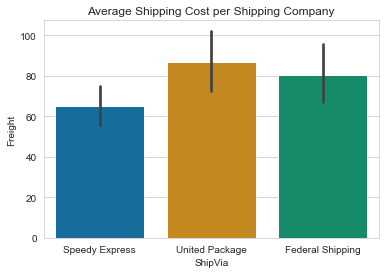

In [76]:
sns.barplot(x='ShipVia', y='Freight', data=orders_region_grouped, palette='colorblind')
plt.xticks(np.arange(3), ('Speedy Express', 'United Package', 'Federal Shipping'), rotation=0)
plt.title('Average Shipping Cost per Shipping Company')
plt.show()

In [59]:
# formula = 'Freight ~ C(ShipVia)'
# lm = ols(formula, orders_region_grouped).fit()
# table = sm.stats.anova_lm(lm, typ=2)
# print(table)

### Is there a difference in shipping speed between the three shipping companies?

In [78]:
orders_region_grouped.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,Central/South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


In [60]:
#test1.info()
orders_region_grouped.ShippedDate.isna().sum()
ord_reg_grp = orders_region_grouped.copy()
ord_reg_grp.dropna(inplace=True)
ord_reg_grp.isna().sum()

Id                0
CustomerId        0
EmployeeId        0
OrderDate         0
RequiredDate      0
ShippedDate       0
ShipVia           0
Freight           0
ShipName          0
ShipAddress       0
ShipCity          0
ShipRegion        0
ShipPostalCode    0
ShipCountry       0
dtype: int64

In [61]:
ord_reg_grp.OrderDate = pd.to_datetime(ord_reg_grp.OrderDate)
ord_reg_grp.ShippedDate = pd.to_datetime(ord_reg_grp.ShippedDate)

time_to_Ship = ord_reg_grp.ShippedDate - ord_reg_grp.OrderDate
ord_reg_grp['Order_Processing'] = (time_to_Ship / np.timedelta64(1, 'D')).astype(int)

ord_reg_grp.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,Order_Processing
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,12
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,5
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,Central/South America,05454-876,Brazil,4
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France,7
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium,2


In [82]:
# test3['Time_to_Ship'] = test3.ShippedDate - test3.OrderDate
# test3.head()

In [83]:
# test3.Time_to_Ship.describe()

In [84]:
# test3['Order_Processing'] = (test3.Time_to_Ship / np.timedelta64(1, 'D')).astype(int)
# test3.head()

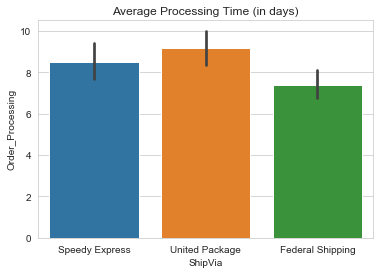

In [62]:
sns.barplot(x='ShipVia', y='Order_Processing', data=ord_reg_grp)
plt.title('Average Processing Time (in days)')
plt.xticks(np.arange(3), ('Speedy Express', 'United Package', 'Federal Shipping'), rotation=0)
plt.show()

In [63]:
processing1 = ord_reg_grp.loc[ord_reg_grp.ShipVia == 1]
processing2 = ord_reg_grp.loc[ord_reg_grp.ShipVia == 2]
processing3 = ord_reg_grp.loc[ord_reg_grp.ShipVia == 3]

In [65]:
# Normality check for order processsing times for the three shipping companies. Commented out to save space

# for shipper in ord_reg_grp.ShipVia.unique():
#     sample = ord_reg_grp.loc[ord_reg_grp.ShipVia == shipper]
#     if shipper == 1:
#         name = 'Speedy Express'
#     elif shipper == 2:
#         name = 'United Package'
#     else:
#         name = 'Federal Shipper'
#     norm_check(sample.Order_Processing, name)


In [64]:
columns = ['ShipCompany1', 'ShipCompany2', 'Variance_Test_p', 'Result']
variance_check_multiple(ship_combos, ord_reg_grp, 'ShipVia', 'Order_Processing', 'no', columns)


,ShipCompany1,ShipCompany2,Variance_Test_p,Result
0,3,1,2.853685e-03,UNEQUAL variance
1,3,2,1.390289e-07,UNEQUAL variance
2,1,2,2.841555e-02,UNEQUAL variance


In [65]:
process_combos = list(itertools.combinations(ord_reg_grp.ShipVia.unique(), 2))

In [66]:
columns = ['Company1', 'Company2', 'Kolmogorov-Smirnov_p', 'Mann_WhitneyU_p', 'KW_p', 'Effect_size']
stats_output(process_combos, ord_reg_grp, 'ShipVia', 'Order_Processing', columns)

,Company1,Company2,Kolmogorov-Smirnov_p,Mann_WhitneyU_p,KW_p,Effect_size
0,3,1,0.291743,0.040752,0.081446,-0.1812
1,3,2,0.125530,0.011376,0.022736,-0.267892
2,1,2,0.959026,0.295044,0.589898,--


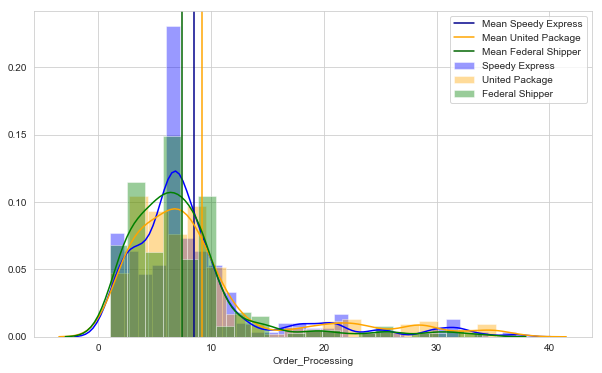

In [67]:
fig = plt.figure(figsize=[10,6])

sns.distplot(processing1.Order_Processing, color='blue', label='Speedy Express')
plt.axvline(processing1.Order_Processing.mean(), color='darkblue', label='Mean Speedy Express')
sns.distplot(processing2.Order_Processing, color='orange', label='United Package')
plt.axvline(processing2.Order_Processing.mean(), color='orange', label='Mean United Package')
sns.distplot(processing3.Order_Processing, color='green', label='Federal Shipper')
plt.axvline(processing3.Order_Processing.mean(), color='darkgreen', label='Mean Federal Shipper')
plt.legend()
plt.show()

In [317]:
# formula = 'Order_Processing ~ C(ShipVia)'
# lm = ols(formula, test3).fit()
# table = sm.stats.anova_lm(lm, typ=2)
# print(table)

In [318]:
# from statsmodels.stats.multicomp import pairwise_tukeyhsd
# from statsmodels.stats.multicomp import MultiComparison

# mc = MultiComparison(test3.Order_Processing, test3.ShipVia)
# result = mc.tukeyhsd()

# print(result)
# print(mc.groupsunique)

In [319]:
#ship3['British_Isles'] = np.where((ship3.ShipRegion == 'British Isles'), 1, 0)

# test3['Speedy_Express'] = np.where((test3.ShipVia == 1), 1, 0)
# test3['United_Package'] = np.where((test3.ShipVia == 2), 1, 0)
# test3['Federal_Shipper'] = np.where((test3.ShipVia == 3), 1, 0)

# test3.head()

In [320]:
# formula = 'Order_Processing ~ Speedy_Express + United_Package + Federal_Shipper'
# lm = ols(formula, test3).fit()
# table = sm.stats.anova_lm(lm, typ=2)
# print(table)

In [68]:
ord_reg_grp.RequiredDate = pd.to_datetime(ord_reg_grp.RequiredDate)
required_time = ord_reg_grp.ShippedDate - ord_reg_grp.RequiredDate
ord_reg_grp['Promised_Time'] = (required_time / np.timedelta64(1, 'D')).astype(int)
ord_reg_grp.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,Order_Processing,Promised_Time
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,12,-16
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,5,-37
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,Central/South America,05454-876,Brazil,4,-24
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France,7,-21
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium,2,-26


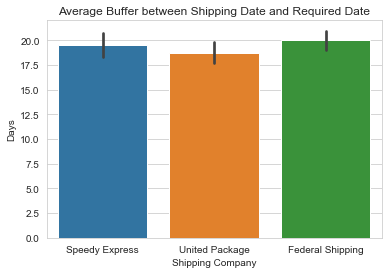

In [69]:
buffer = ord_reg_grp.Promised_Time * -1
sns.barplot(x='ShipVia', y=buffer, data=ord_reg_grp)
plt.title('Average Buffer between Shipping Date and Required Date')
plt.ylabel('Days')
plt.xlabel('Shipping Company')
plt.xticks(np.arange(3), ('Speedy Express', 'United Package', 'Federal Shipping'), rotation=0)
plt.show()

In [70]:
failures = ord_reg_grp.loc[ord_reg_grp.Promised_Time > 0]
failures.shape


(34, 16)

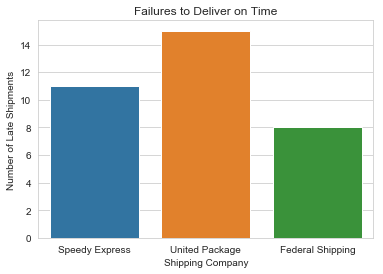

In [71]:
sns.countplot(x= 'ShipVia', data=failures)
plt.title('Failures to Deliver on Time')
plt.xticks(np.arange(3), ('Speedy Express', 'United Package', 'Federal Shipping'), rotation=0)
plt.ylabel('Number of Late Shipments')
plt.xlabel('Shipping Company')
plt.show()

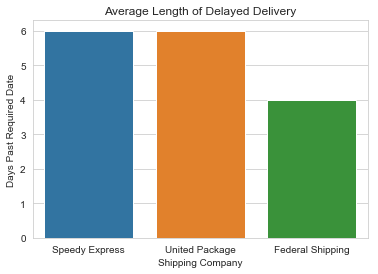

In [72]:
sns.barplot(x='ShipVia', y='Promised_Time', data=failures, ci=0)
plt.title('Average Length of Delayed Delivery')
plt.xticks(np.arange(3), ('Speedy Express', 'United Package', 'Federal Shipping'), rotation=0)
plt.ylabel('Days Past Required Date')
plt.xlabel('Shipping Company')
plt.show()

### Does the size of the order affect how long it takes to ship?

In [197]:
col_names('OrderDetail')

2019-04-01 13:19:29,430 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("OrderDetail")
2019-04-01 13:19:29,431 INFO sqlalchemy.engine.base.Engine ()


['Id', 'OrderId', 'ProductId', 'UnitPrice', 'Quantity', 'Discount']

In [78]:
# q4 = '''SELECT d.OrderId, d.UnitPrice, d.Quantity, d.Discount, o.OrderDate, o.ShippedDate, o.ShipVia, o.ShipRegion
# FROM [Order] o JOIN OrderDetail d on o.Id=d.OrderId'''
# order_size_main = pd.read_sql_query(q4, engine)
# order_size_main.head()


In [73]:
order_size_main = join_2('[Order] o', 'OrderDetail d', '''d.OrderId, d.UnitPrice, d.Quantity, d.Discount, 
o.OrderDate, o.ShippedDate, o.ShipVia, o.ShipRegion''', 'o.Id=d.OrderId')
order_size_main.head()


2019-04-04 13:22:42,009 INFO sqlalchemy.engine.base.Engine SELECT d.OrderId, d.UnitPrice, d.Quantity, d.Discount, 
o.OrderDate, o.ShippedDate, o.ShipVia, o.ShipRegion FROM [Order] o JOIN OrderDetail d on o.Id=d.OrderId
2019-04-04 13:22:42,010 INFO sqlalchemy.engine.base.Engine ()


,OrderId,UnitPrice,Quantity,Discount,OrderDate,ShippedDate,ShipVia,ShipRegion
0,10248,14.0,12,0.0,2012-07-04,2012-07-16,3,Western Europe
1,10248,9.8,10,0.0,2012-07-04,2012-07-16,3,Western Europe
2,10248,34.8,5,0.0,2012-07-04,2012-07-16,3,Western Europe
3,10249,18.6,9,0.0,2012-07-05,2012-07-10,1,Western Europe
4,10249,42.4,40,0.0,2012-07-05,2012-07-10,1,Western Europe


In [74]:
order_size_main.dropna(inplace=True)
order_size_main.OrderDate = pd.to_datetime(order_size_main.OrderDate)
order_size_main.ShippedDate = pd.to_datetime(order_size_main.ShippedDate)
times =  order_size_main.ShippedDate - order_size_main.OrderDate
order_size_main['Order_Processing'] = (times / np.timedelta64(1, 'D')).astype(int)
order_size_main.head()

,OrderId,UnitPrice,Quantity,Discount,OrderDate,ShippedDate,ShipVia,ShipRegion,Order_Processing
0,10248,14.0,12,0.0,2012-07-04,2012-07-16,3,Western Europe,12
1,10248,9.8,10,0.0,2012-07-04,2012-07-16,3,Western Europe,12
2,10248,34.8,5,0.0,2012-07-04,2012-07-16,3,Western Europe,12
3,10249,18.6,9,0.0,2012-07-05,2012-07-10,1,Western Europe,5
4,10249,42.4,40,0.0,2012-07-05,2012-07-10,1,Western Europe,5


In [75]:
totals = []
for order in order_size_main.OrderId.unique():
    temp = order_size_main.loc[order_size_main.OrderId == order]
    tot = sum(temp.Quantity)
    pro = temp.Order_Processing.mean()
    ship = temp.ShipVia.mean()
    totals.append([order, ship, pro, tot])
len(totals)

809

In [76]:
order_size = pd.DataFrame(totals, columns=['Order', 'ShipComp', 'ProcessingTime', 'Total_Quantity'])
order_size.head()

,Order,ShipComp,ProcessingTime,Total_Quantity
0,10248,3.0,12.0,27
1,10249,1.0,5.0,49
2,10250,2.0,4.0,60
3,10251,1.0,7.0,41
4,10252,2.0,2.0,105


In [77]:
quant_ship1 = order_size.loc[order_size.ShipComp == 1]
quant_ship2 = order_size.loc[order_size.ShipComp == 2]
quant_ship3 = order_size.loc[order_size.ShipComp == 3]

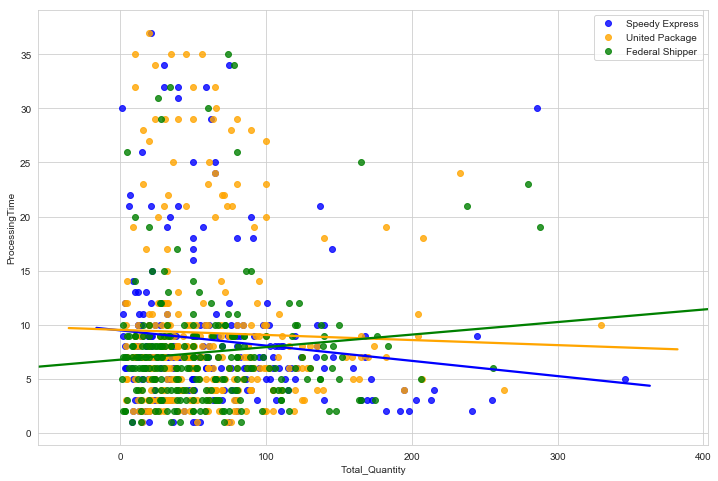

In [78]:
#sns.set_style('darkgrid')
fig = plt.figure(figsize=[12,8])

sns.regplot(x='Total_Quantity', y='ProcessingTime', data=quant_ship1, color='blue', ci=0, label='Speedy Express')
sns.regplot(x='Total_Quantity', y='ProcessingTime', data=quant_ship2, color='orange', ci=0, label='United Package')
sns.regplot(x='Total_Quantity', y='ProcessingTime', data=quant_ship3, color='green', ci=0, label='Federal Shipper')
plt.legend()

plt.show()

In [79]:
#eval_size = order_size.copy()

sizes = []

for val in order_size.Total_Quantity:
    if val <= 30:
        c = 'Small'
    elif val >= 31 and val <=75:
        c = 'Medium'
    else:
        c = 'Large'
    sizes.append(c)

order_size['Order_Size'] = sizes

In [80]:
order_size.head()

,Order,ShipComp,ProcessingTime,Total_Quantity,Order_Size
0,10248,3.0,12.0,27,Small
1,10249,1.0,5.0,49,Medium
2,10250,2.0,4.0,60,Medium
3,10251,1.0,7.0,41,Medium
4,10252,2.0,2.0,105,Large


In [81]:
size_speedy = order_size.loc[order_size.ShipComp == 1]
size_united = order_size.loc[order_size.ShipComp == 2]
size_federal = order_size.loc[order_size.ShipComp == 3]

In [82]:
size_combos = list(itertools.combinations(order_size.Order_Size.unique(), 2))

In [83]:
columns = ['Size1', 'Size2', 'KS_p', 'MWU_p', 'KW_p', 'Effect_Size']
stats_output(size_combos, order_size, 'Order_Size', 'ProcessingTime', columns)

,Size1,Size2,KS_p,MWU_p,KW_p,Effect_Size
0,Small,Medium,0.630959,0.218563,0.436972,--
1,Small,Large,0.077420,0.059275,0.118475,--
2,Medium,Large,0.863411,0.211040,0.421926,--


In [120]:
# souts = []
# for combo in Scombos:
#     samp1 = order_size.loc[order_size.Order_Size == combo[0]]
#     samp2 = order_size.loc[order_size.Order_Size == combo[1]]
#     nps = non_parametric(samp1.ProcessingTime, samp2.ProcessingTime, name=None)
#     souts.append([combo[0], combo[1], nps[0][0], nps[0][1], nps[0][2], nps[0][3]])

# sout_df = pd.DataFrame(souts, columns=['Size1', 'Size2', 'KS_p', 'MWU_p', 'KW_p', 'EffectSize'])
# sout_df

In [122]:
# comp_combos = list(itertools.combinations(order_size.ShipComp.unique(), 2))

In [85]:
columns = ['Size1', 'Size2', 'Kolmogorov-Smirnov_p', 'Mann_WhitneyU_p', 'KW_p', 'Effect_Size']
stats_output(size_combos, size_speedy, 'Order_Size', 'ProcessingTime', columns)

,Size1,Size2,Kolmogorov-Smirnov_p,Mann_WhitneyU_p,KW_p,Effect_Size
0,Small,Medium,0.386104,0.13499,0.269287,--
1,Small,Large,0.044176,0.00919,0.018293,0.355378
2,Medium,Large,0.463360,0.07540,0.150338,--


In [86]:
columns = ['Size1', 'Size2', 'Kolmogorov-Smirnov_p', 'Mann_WhitneyU_p', 'KW_p', 'Effect_Size']
stats_output(size_combos, size_united, 'Order_Size', 'ProcessingTime', columns)

,Size1,Size2,Kolmogorov-Smirnov_p,Mann_WhitneyU_p,KW_p,Effect_Size
0,Small,Medium,0.921219,0.337227,0.673685,--
1,Small,Large,0.714763,0.295572,0.590137,--
2,Medium,Large,0.804061,0.145431,0.290389,--


In [87]:
columns = ['Size1', 'Size2', 'Kolmogorov-Smirnov_p', 'Mann_WhitneyU_p', 'KW_p', 'Effect_Size']
stats_output(size_combos, size_federal, 'Order_Size', 'ProcessingTime', columns)

,Size1,Size2,Kolmogorov-Smirnov_p,Mann_WhitneyU_p,KW_p,Effect_Size
0,Small,Medium,0.141693,0.094107,0.187703,--
1,Small,Large,0.941499,0.443834,0.886325,--
2,Medium,Large,0.519305,0.073959,0.147454,--


In [127]:
# ssouts = []
# for combo in Scombos:
#     samp1 = sizeS.loc[sizeS.Order_Size == combo[0]]
#     samp2 = sizeS.loc[sizeS.Order_Size == combo[1]]
#     nps = non_parametric(samp1.ProcessingTime, samp2.ProcessingTime, name=None)
#     ssouts.append([combo[0], combo[1], nps[0][0], nps[0][1], nps[0][2], nps[0][3]])

# ssout_df = pd.DataFrame(ssouts, columns=['Size1', 'Size2', 'KS_p', 'MWU_p', 'KW_p', 'EffectSize'])
# ssout_df

In [128]:
# ssouts = []
# for combo in Scombos:
#     samp1 = sizeU.loc[sizeU.Order_Size == combo[0]]
#     samp2 = sizeU.loc[sizeU.Order_Size == combo[1]]
#     nps = non_parametric(samp1.ProcessingTime, samp2.ProcessingTime, name=None)
#     ssouts.append([combo[0], combo[1], nps[0][0], nps[0][1], nps[0][2], nps[0][3]])

# ssout_df = pd.DataFrame(ssouts, columns=['Size1', 'Size2', 'KS_p', 'MWU_p', 'KW_p', 'EffectSize'])
# ssout_df

In [129]:
# ssouts = []
# for combo in Scombos:
#     samp1 = sizeF.loc[sizeF.Order_Size == combo[0]]
#     samp2 = sizeF.loc[sizeF.Order_Size == combo[1]]
#     nps = non_parametric(samp1.ProcessingTime, samp2.ProcessingTime, name=None)
#     ssouts.append([combo[0], combo[1], nps[0][0], nps[0][1], nps[0][2], nps[0][3]])

# ssout_df = pd.DataFrame(ssouts, columns=['Size1', 'Size2', 'KS_p', 'MWU_p', 'KW_p', 'EffectSize'])
# ssout_df

In [46]:
# formula = 'ProcessingTime ~ Total_Quantity'
# lm = ols(formula, size1).fit()
# table = sm.stats.anova_lm(lm, typ=2)
# print(table)

# formula = 'ProcessingTime ~ Total_Quantity'
# lm = ols(formula, size2).fit()
# table = sm.stats.anova_lm(lm, typ=2)
# print(table)

# formula = 'ProcessingTime ~ Total_Quantity'
# lm = ols(formula, size3).fit()
# table = sm.stats.anova_lm(lm, typ=2)
# print(table)

In [344]:
# formula = 'ProcessingTime ~ Total_Quantity'
# lm = ols(formula, test5).fit()
# table = sm.stats.anova_lm(lm, typ=2)
# print(table)

In [ ]:


# mc = MultiComparison(test5., test5.Discount_Median)
# result = mc.tukeyhsd()

# print(result)
# print(mc.groupsunique)

In [337]:
# formula = 'ProcessingTime ~ Total_Quantity + C(ShipComp)'
# lm = ols(formula, test5).fit()
# table = sm.stats.anova_lm(lm, typ=2)
# print(table)

In [336]:
# sup = make_df('Supplier', cols='Id, CompanyName, Region')
# sup.shape

### Is there a difference in order quantities/totals between contact types?

In [95]:
# q5 = '''SELECT c.CompanyName, c.ContactTitle, d.OrderId, d.UnitPrice, d.Quantity, d.Discount FROM Customer c JOIN [Order] o
# on c.Id = o.CustomerId JOIN OrderDetail d on d.OrderId = o.Id'''
# contacts_main = pd.read_sql_query(q5, engine)
# contacts_main.head()

In [88]:
contacts_main = join_3('Customer c', '[Order] o', 'OrderDetail d', '''c.CompanyName, c.ContactTitle, d.OrderId, 
d.UnitPrice, d.Quantity, d.Discount''', 'c.Id = o.CustomerId', 'd.OrderId = o.Id')
contacts_main.head()

2019-04-04 13:28:48,962 INFO sqlalchemy.engine.base.Engine SELECT c.CompanyName, c.ContactTitle, d.OrderId, 
d.UnitPrice, d.Quantity, d.Discount FROM Customer c JOIN [Order] o on c.Id = o.CustomerId JOIN OrderDetail d on d.OrderId = o.Id
2019-04-04 13:28:48,963 INFO sqlalchemy.engine.base.Engine ()


,CompanyName,ContactTitle,OrderId,UnitPrice,Quantity,Discount
0,Vins et alcools Chevalier,Accounting Manager,10248,14.0,12,0.0
1,Vins et alcools Chevalier,Accounting Manager,10248,9.8,10,0.0
2,Vins et alcools Chevalier,Accounting Manager,10248,34.8,5,0.0
3,Toms Spezialitäten,Marketing Manager,10249,18.6,9,0.0
4,Toms Spezialitäten,Marketing Manager,10249,42.4,40,0.0


In [89]:
results = []
for order in contacts_main.OrderId.unique():
    temp = contacts_main.loc[contacts_main.OrderId == order]
    quant = sum(temp.Quantity)
    cost = sum(temp.UnitPrice * temp.Quantity * (1-temp.Discount))
    results.append([order, temp.CompanyName.max(), temp.ContactTitle.max(), quant, cost])

len(results)

801

In [90]:
contacts = pd.DataFrame(results, columns=['Order', 'Company', 'Contact', 'Quantity', 'Total'])
contacts.head()

,Order,Company,Contact,Quantity,Total
0,10248,Vins et alcools Chevalier,Accounting Manager,27,440.00
1,10249,Toms Spezialitäten,Marketing Manager,49,1863.40
2,10250,Hanari Carnes,Accounting Manager,60,1552.60
3,10251,Victuailles en stock,Sales Agent,41,654.06
4,10252,Suprêmes délices,Accounting Manager,105,3597.90


In [136]:
contacts.Contact.unique()

array(['Accounting Manager', 'Marketing Manager', 'Sales Agent', 'Owner',
       'Sales Manager', 'Sales Representative',
       'Assistant Sales Representative', 'Marketing Assistant',
       'Order Administrator', 'Assistant Sales Agent', 'Sales Associate',
       'Owner/Marketing Assistant'], dtype=object)

In [137]:
contacts.Contact.value_counts()

Sales Representative              160
Sales Manager                     128
Owner                             123
Accounting Manager                116
Marketing Manager                  82
Sales Associate                    65
Sales Agent                        31
Marketing Assistant                31
Order Administrator                24
Assistant Sales Representative     18
Assistant Sales Agent              16
Owner/Marketing Assistant           7
Name: Contact, dtype: int64

In [1]:
# fig, axes = plt.subplots(1,3, figsize=[14,6])

sns.countplot(contacts.Contact, palette='colorblind')
plt.xticks(np.arange(12), ('Accounting Manager', 'Marketing Manager', 'Sales Agent', 'Owner', 
                          'Sales Manager', 'Sales Representative', 'Asst. Sales Representative',
                          'Marketing Assistant', 'Order Administrator', 'Asst. Sales Agent', 'Sales Associate',
                          'Owner/Marketing Asst.'), 
           rotation=45)
plt.title('Number of Orders by Customer Contact Types')
plt.ylabel('Number of Orders')
plt.xlabel('Customer Contact')



NameError: name 'plt' is not defined

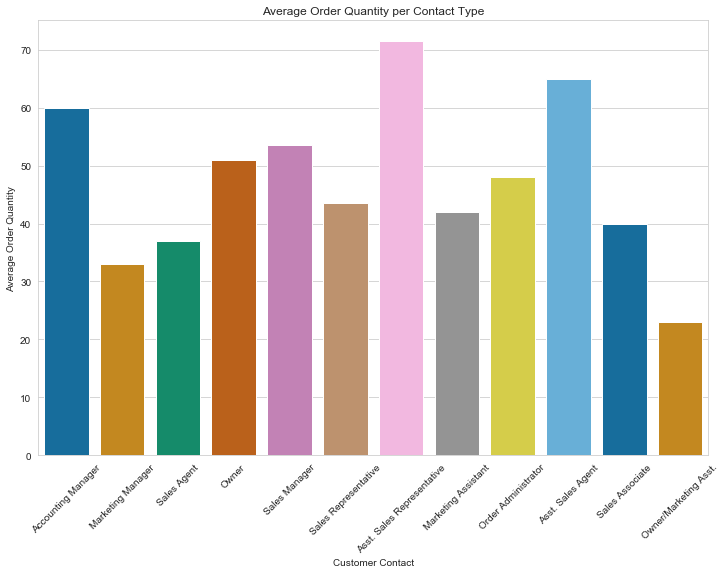

In [92]:
fig=plt.figure(figsize=[12,8])
sns.barplot(x='Contact', y='Quantity', data=contacts, estimator=median, ci=0, palette='colorblind')
plt.xticks(np.arange(12), ('Accounting Manager', 'Marketing Manager', 'Sales Agent', 'Owner', 
                          'Sales Manager', 'Sales Representative', 'Asst. Sales Representative',
                          'Marketing Assistant', 'Order Administrator', 'Asst. Sales Agent', 'Sales Associate',
                          'Owner/Marketing Asst.'), 
           rotation=45)
plt.title('Average Order Quantity per Contact Type')
plt.ylabel('Average Order Quantity')
plt.xlabel('Customer Contact')
plt.show()

In [56]:
# formula = 'Quantity ~ C(Contact)'
# lm = ols(formula, test6).fit()
# table = sm.stats.anova_lm(lm, typ=2)
# print(table)

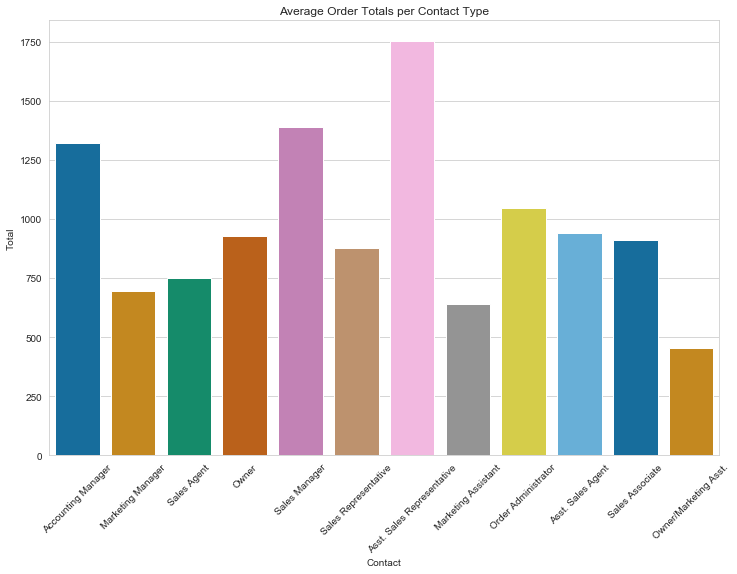

In [93]:
fig=plt.figure(figsize=[12,8])
sns.barplot(x='Contact', y='Total', data=contacts, estimator=median, ci=0, palette='colorblind')
plt.xticks(np.arange(12), ('Accounting Manager', 'Marketing Manager', 'Sales Agent', 'Owner', 
                          'Sales Manager', 'Sales Representative', 'Asst. Sales Representative',
                          'Marketing Assistant', 'Order Administrator', 'Asst. Sales Agent', 'Sales Associate',
                          'Owner/Marketing Asst.'), 
           rotation=45)
plt.title('Average Order Totals per Contact Type')
plt.show()

In [141]:
contacts.Contact.unique()

array(['Accounting Manager', 'Marketing Manager', 'Sales Agent', 'Owner',
       'Sales Manager', 'Sales Representative',
       'Assistant Sales Representative', 'Marketing Assistant',
       'Order Administrator', 'Assistant Sales Agent', 'Sales Associate',
       'Owner/Marketing Assistant'], dtype=object)

In [94]:
contact_combos = list(itertools.combinations(contacts.Contact.unique(), 2))

In [95]:
columns = ['Contact1', 'Contact2', 'Kolmogorov-Smirnov_p', 'Mann_WhitneyU_p', 'KW_p', 'Effect_Size']
ctype = stats_output(contact_combos, contacts, 'Contact', 'Total', columns)
ctype.replace({'--': np.nan}, inplace=True)
ctype.dropna(inplace=True)
ctype

,Contact1,Contact2,Kolmogorov-Smirnov_p,Mann_WhitneyU_p,KW_p,Effect_Size
0,Accounting Manager,Marketing Manager,0.008931,0.000298,0.000594,0.387870
1,Accounting Manager,Sales Agent,0.101346,0.026496,0.052701,0.349403
2,Accounting Manager,Owner,0.119908,0.037593,0.075033,0.291612
4,Accounting Manager,Sales Representative,0.063045,0.016099,0.032136,0.271822
5,Accounting Manager,Assistant Sales Representative,0.152949,0.029018,0.057606,-0.319350
6,Accounting Manager,Marketing Assistant,0.039816,0.013053,0.025946,0.271081
10,Accounting Manager,Owner/Marketing Assistant,0.000660,0.002153,0.004233,0.597502
12,Marketing Manager,Owner,0.047881,0.011718,0.023362,-0.164614
13,Marketing Manager,Sales Manager,0.008541,0.000918,0.001828,-0.403044
14,Marketing Manager,Sales Representative,0.065845,0.028316,0.056507,-0.187789


In [96]:
strong_effect = ctype.loc[(ctype.Effect_Size > 0.5) | (ctype.Effect_Size < -0.5)]
strong_effect

,Contact1,Contact2,Kolmogorov-Smirnov_p,Mann_WhitneyU_p,KW_p,Effect_Size
10,Accounting Manager,Owner/Marketing Assistant,0.000660,0.002153,0.004233,0.597502
15,Marketing Manager,Assistant Sales Representative,0.006268,0.000163,0.000321,-0.939688
20,Marketing Manager,Owner/Marketing Assistant,0.043282,0.115766,0.228573,0.500653
24,Sales Agent,Assistant Sales Representative,0.008293,0.002037,0.003943,-0.825626
29,Sales Agent,Owner/Marketing Assistant,0.014786,0.029865,0.057223,0.749651
32,Owner,Assistant Sales Representative,0.018976,0.001380,0.002732,-0.835203
37,Owner,Owner/Marketing Assistant,0.002186,0.005922,0.011671,0.632698
39,Sales Manager,Assistant Sales Representative,0.063755,0.033156,0.065873,-0.528971
44,Sales Manager,Owner/Marketing Assistant,0.001664,0.006644,0.013105,0.767884
45,Sales Representative,Assistant Sales Representative,0.008772,0.001422,0.002822,-0.793567


In [112]:
contacts.Contact.value_counts()

Sales Representative              160
Sales Manager                     128
Owner                             123
Accounting Manager                116
Marketing Manager                  82
Sales Associate                    65
Marketing Assistant                31
Sales Agent                        31
Order Administrator                24
Assistant Sales Representative     18
Assistant Sales Agent              16
Owner/Marketing Assistant           7
Name: Contact, dtype: int64

In [97]:
grouped_contacts = contacts.copy()

#test1.loc[(test1.ShipRegion == 'Central America') | (test1.ShipRegion == 'South America'), 'ShipRegion'] = 
#'Central/South America'

grouped_contacts.loc[(grouped_contacts.Contact == 'Owner') | 
                     (grouped_contacts.Contact == 'Owner/Marketing Assistant'), 'Contact'] = 'Owner'
grouped_contacts.loc[(grouped_contacts.Contact == 'Accounting Manager') | 
                     (grouped_contacts.Contact == 'Marketing Manager') | 
                     (grouped_contacts.Contact == 'Sales Manager'), 'Contact'] = 'Management'
grouped_contacts.loc[(grouped_contacts.Contact == 'Sales Agent') | 
                     (grouped_contacts.Contact == 'Sales Representative') | 
                     (grouped_contacts.Contact == 'Sales Associate'), 'Contact'] = 'Rep/Agent/Associate'
grouped_contacts.loc[(grouped_contacts.Contact == 'Assistant Sales Representative') | 
                     (grouped_contacts.Contact == 'Marketing Assistant') | 
                     (grouped_contacts.Contact == 'Assistant Sales Agent') | 
                     (grouped_contacts.Contact == 'Order Administrator'), 'Contact'] = 'Assistant/Admin'

In [113]:
grouped_contacts.Contact.value_counts()

Management             326
Rep/Agent/Associate    256
Owner                  130
Assistant/Admin         89
Name: Contact, dtype: int64

In [98]:
contact_owner = grouped_contacts.loc[grouped_contacts.Contact == 'Owner']
contact_manage = grouped_contacts.loc[grouped_contacts.Contact == 'Management']
contact_rep = grouped_contacts.loc[grouped_contacts.Contact == 'Rep/Agent/Associate']
contact_asst = grouped_contacts.loc[grouped_contacts.Contact == 'Assistant/Admin']

In [156]:
# norm_check(contact_owner.Total, 'Owners')
# norm_check(contact_manage.Total, 'Management')
# norm_check(contact_rep.Total, 'Reps')
# norm_check(contact_asst.Total, 'Assistants')

In [99]:
con_grp_combos = list(itertools.combinations(grouped_contacts.Contact.unique(), 2))

In [110]:
# Normality check for contact groups

# for contact_type in grouped_contacts.Contact.unique():
#     sample = grouped_contacts.loc[grouped_contacts.Contact == contact_type]
#     norm_check(sample.Total, contact_type)

In [100]:
columns=['Contact1', 'Contact2', 'Variance_Test_p', 'Result']
variance_check_multiple(con_grp_combos, grouped_contacts, 'Contact', 'Total', 'no', columns)

,Contact1,Contact2,Variance_Test_p,Result
0,Management,Rep/Agent/Associate,0.000470,UNEQUAL variance
1,Management,Owner,0.000005,UNEQUAL variance
2,Management,Assistant/Admin,0.554643,EQUAL variance
3,Rep/Agent/Associate,Owner,0.060517,EQUAL variance
4,Rep/Agent/Associate,Assistant/Admin,0.063363,EQUAL variance
5,Owner,Assistant/Admin,0.001648,UNEQUAL variance


In [161]:
# fig = plt.figure(figsize=[10,6])
# sns.distplot(ctype_o.Total, color='blue', label='Owners')
# plt.axvline(x=ctype_o.Total.mean(), color='darkblue')
# sns.distplot(ctype_m.Total, color='orange', label='Management')
# plt.axvline(x=ctype_m.Total.mean(), color='orange')
# sns.distplot(ctype_a.Total, color='green', label='Lower Levels')
# plt.axvline(x=ctype_a.Total.mean(), color='darkgreen')
# plt.legend()
# plt.show()

In [103]:
columns=['Contact1', 'Contact2', 'Kolmogorov_Smirnov_p', 'Mann_WhitneyU_p', 'KW_p', 'Effect_size']
stats_output(con_grp_combos, grouped_contacts, 'Contact', 'Total', columns)

,Contact1,Contact2,Kolmogorov_Smirnov_p,Mann_WhitneyU_p,KW_p,Effect_size
0,Management,Rep/Agent/Associate,0.120446,0.070210,0.140353,--
1,Management,Owner,0.102710,0.135488,0.270805,--
2,Management,Assistant/Admin,0.988648,0.484689,0.968980,--
3,Rep/Agent/Associate,Owner,0.938754,0.406340,0.812305,--
4,Rep/Agent/Associate,Assistant/Admin,0.271686,0.151312,0.302334,--
5,Owner,Assistant/Admin,0.335094,0.194944,0.389289,--


In [61]:
# def mann_whit(sample1, sample2):
#     mwu = stats.mannwhitneyu(sample1, sample2)
#     return round(mwu[1],3)

In [62]:
# def kruskal_wallis(sample1, sample2):
#     kw = stats.kruskal(sample1, sample2)
#     return round(kw[1], 4)

In [137]:
# formula = 'Total ~ C(Contact)'
# lm = ols(formula, test6).fit()
# table = sm.stats.anova_lm(lm, typ=2)
# print(table)

In [139]:
col_names('Supplier')

2019-04-03 10:57:20,580 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Supplier")
2019-04-03 10:57:20,581 INFO sqlalchemy.engine.base.Engine ()


['Id',
 'CompanyName',
 'ContactName',
 'ContactTitle',
 'Address',
 'City',
 'Region',
 'PostalCode',
 'Country',
 'Phone',
 'Fax',
 'HomePage']

In [115]:
# q_sup = '''SELECT s.Id, s.CompanyName, p.ProductName, p.CategoryId, d.OrderId, o.OrderDate,
# o.RequiredDate, o.ShippedDate, o.ShipVia, o.CustomerId FROM [Order] o JOIN OrderDetail d on o.Id=d.OrderId 
# JOIN Product p on d.ProductId=p.Id JOIN Supplier s on p.SupplierId=s.Id'''

# sup = pd.read_sql_query(q_sup, engine)
# sup.head()

In [104]:
supplier = join_4('[Order] o', 'OrderDetail d', 'Product p', 'Supplier s', '''s.Id, s.CompanyName, p.ProductName, 
p.CategoryId, d.OrderId, o.OrderDate, o.RequiredDate, o.ShippedDate, o.ShipVia, o.CustomerId''', 'o.Id=d.OrderId', 
                 'd.ProductId=p.Id', 'p.SupplierId=s.Id')
supplier.head()

2019-04-04 13:32:56,550 INFO sqlalchemy.engine.base.Engine SELECT s.Id, s.CompanyName, p.ProductName, 
p.CategoryId, d.OrderId, o.OrderDate, o.RequiredDate, o.ShippedDate, o.ShipVia, o.CustomerId FROM [Order] o JOIN OrderDetail d on o.Id=d.OrderId JOIN Product p on d.ProductId=p.Id JOIN Supplier s on p.SupplierId=s.Id
2019-04-04 13:32:56,551 INFO sqlalchemy.engine.base.Engine ()


,Id,CompanyName,ProductName,CategoryId,OrderId,OrderDate,RequiredDate,ShippedDate,ShipVia,CustomerId
0,5,Cooperativa de Quesos 'Las Cabras',Queso Cabrales,4,10248,2012-07-04,2012-08-01,2012-07-16,3,VINET
1,20,Leka Trading,Singaporean Hokkien Fried Mee,5,10248,2012-07-04,2012-08-01,2012-07-16,3,VINET
2,14,Formaggi Fortini s.r.l.,Mozzarella di Giovanni,4,10248,2012-07-04,2012-08-01,2012-07-16,3,VINET
3,6,Mayumi's,Tofu,7,10249,2012-07-05,2012-08-16,2012-07-10,1,TOMSP
4,24,"G'day, Mate",Manjimup Dried Apples,7,10249,2012-07-05,2012-08-16,2012-07-10,1,TOMSP


In [125]:
supplier.CompanyName.value_counts()

Plutzer Lebensmittelgroßmärkte AG         171
Pavlova, Ltd.                             158
Specialty Biscuits, Ltd.                  122
Norske Meierier                           102
Formaggi Fortini s.r.l.                   102
Gai pâturage                              101
G'day, Mate                                95
Exotic Liquids                             88
New England Seafood Cannery                86
Leka Trading                               81
Pasta Buttini s.r.l.                       72
Forêts d'érables                           71
New Orleans Cajun Delights                 68
Ma Maison                                  67
Karkki Oy                                  66
Mayumi's                                   63
Bigfoot Breweries                          62
Heli Süßwaren GmbH & Co. KG                59
Aux joyeux ecclésiastiques                 53
Tokyo Traders                              50
Cooperativa de Quesos 'Las Cabras'         50
Svensk Sjöföda AB                 

In [116]:
supplier.isna().sum()

Id               0
CompanyName      0
ProductName      0
CategoryId       0
OrderId          0
OrderDate        0
RequiredDate     0
ShippedDate     73
ShipVia          0
CustomerId       0
dtype: int64

In [105]:
supplier.dropna(inplace=True)
supplier.OrderDate = pd.to_datetime(supplier.OrderDate)
supplier.ShippedDate = pd.to_datetime(supplier.ShippedDate)
times =  supplier.ShippedDate - supplier.OrderDate
supplier['Order_Processing'] = (times / np.timedelta64(1, 'D')).astype(int)
supplier.head()

,Id,CompanyName,ProductName,CategoryId,OrderId,OrderDate,RequiredDate,ShippedDate,ShipVia,CustomerId,Order_Processing
0,5,Cooperativa de Quesos 'Las Cabras',Queso Cabrales,4,10248,2012-07-04,2012-08-01,2012-07-16,3,VINET,12
1,20,Leka Trading,Singaporean Hokkien Fried Mee,5,10248,2012-07-04,2012-08-01,2012-07-16,3,VINET,12
2,14,Formaggi Fortini s.r.l.,Mozzarella di Giovanni,4,10248,2012-07-04,2012-08-01,2012-07-16,3,VINET,12
3,6,Mayumi's,Tofu,7,10249,2012-07-05,2012-08-16,2012-07-10,1,TOMSP,5
4,24,"G'day, Mate",Manjimup Dried Apples,7,10249,2012-07-05,2012-08-16,2012-07-10,1,TOMSP,5


In [106]:
supplier_combos = list(itertools.combinations(supplier.CompanyName.unique(), 2))

In [107]:
columns = ['Supplier1', 'Supplier2', 'KS_p', 'MWU_p', 'KW_p', 'Effect_Size']
stype = stats_output(supplier_combos, supplier, 'CompanyName', 'Order_Processing', columns)
stype.replace({'--': np.nan}, inplace=True)
stype.dropna(inplace=True)
stype

,Supplier1,Supplier2,KS_p,MWU_p,KW_p,Effect_Size
28,Leka Trading,Formaggi Fortini s.r.l.,0.075685,0.024421,0.048680,0.214362
30,Leka Trading,"G'day, Mate",0.100181,0.047729,0.095163,0.178777
37,Leka Trading,Gai pâturage,0.106120,0.023343,0.046530,0.163461
50,Leka Trading,Grandma Kelly's Homestead,0.131712,0.026167,0.052042,0.218524
51,Leka Trading,Nord-Ost-Fisch Handelsgesellschaft mbH,0.117246,0.019950,0.039586,0.332992
52,Leka Trading,Lyngbysild,0.051244,0.009597,0.019047,0.441720
53,Leka Trading,Escargots Nouveaux,0.191632,0.041298,0.081794,0.409495
64,Formaggi Fortini s.r.l.,Aux joyeux ecclésiastiques,0.048998,0.015012,0.029881,-0.276308
65,Formaggi Fortini s.r.l.,Karkki Oy,0.014127,0.004791,0.009537,-0.349768
72,Formaggi Fortini s.r.l.,Plutzer Lebensmittelgroßmärkte AG,0.066148,0.042460,0.084777,-0.201114


In [108]:
strong_effect = stype.loc[(stype.Effect_Size > 0.5) | (stype.Effect_Size < -0.5)]
strong_effect

,Supplier1,Supplier2,KS_p,MWU_p,KW_p,Effect_Size
283,Aux joyeux ecclésiastiques,Lyngbysild,0.026068,0.006879,0.013604,0.537014
284,Aux joyeux ecclésiastiques,Escargots Nouveaux,0.174706,0.024285,0.047817,0.501138
298,Karkki Oy,Lyngbysild,0.016235,0.002268,0.004488,0.583845
299,Karkki Oy,Escargots Nouveaux,0.109805,0.014685,0.028965,0.543725


In [ ]:
for company in supplier.CompanyName.unique():
    

In [126]:
sup_dummies = pd.get_dummies(supplier.CompanyName)

In [127]:
supplier_dummies = pd.concat([supplier, sup_dummies], axis=1)
supplier_dummies.head()

,Id,CompanyName,ProductName,CategoryId,OrderId,OrderDate,RequiredDate,ShippedDate,ShipVia,CustomerId,...,Norske Meierier,PB Knäckebröd AB,Pasta Buttini s.r.l.,"Pavlova, Ltd.",Plutzer Lebensmittelgroßmärkte AG,Refrescos Americanas LTDA,"Specialty Biscuits, Ltd.",Svensk Sjöföda AB,Tokyo Traders,Zaanse Snoepfabriek
0,5,Cooperativa de Quesos 'Las Cabras',Queso Cabrales,4,10248,2012-07-04,2012-08-01,2012-07-16,3,VINET,...,0,0,0,0,0,0,0,0,0,0
1,20,Leka Trading,Singaporean Hokkien Fried Mee,5,10248,2012-07-04,2012-08-01,2012-07-16,3,VINET,...,0,0,0,0,0,0,0,0,0,0
2,14,Formaggi Fortini s.r.l.,Mozzarella di Giovanni,4,10248,2012-07-04,2012-08-01,2012-07-16,3,VINET,...,0,0,0,0,0,0,0,0,0,0
3,6,Mayumi's,Tofu,7,10249,2012-07-05,2012-08-16,2012-07-10,1,TOMSP,...,0,0,0,0,0,0,0,0,0,0
4,24,"G'day, Mate",Manjimup Dried Apples,7,10249,2012-07-05,2012-08-16,2012-07-10,1,TOMSP,...,0,0,0,0,0,0,0,0,0,0


In [129]:
formula = 'Order_Processing ~ C(CompanyName)'
lm = ols(formula, supplier).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                      sum_sq      df         F    PR(>F)
C(CompanyName)   1212.894034    28.0  0.966603  0.515096
Residual        92003.805774  2053.0       NaN       NaN


### Does Age of employee affect order total? Does experience with the company affect order total?

In [111]:
# q6 = '''SELECT e.LastName, e.Id, e.BirthDate, e.HireDate, e.Title, d.OrderId, d.UnitPrice, d.Quantity, d.Discount,
# o.OrderDate, o.Freight, o.CustomerId FROM Employee e JOIN [Order] o on e.Id=o.EmployeeId JOIN OrderDetail d on d.OrderId=o.Id'''
# employee_main = pd.read_sql_query(q6, engine)
# employee_main.head()



In [112]:
employee_main = join_3('Employee e', '[Order] o', 'OrderDetail d', '''e.LastName, e.Id, e.BirthDate, e.HireDate, 
e.Title, d.OrderId, d.UnitPrice, d.Quantity, d.Discount, o.OrderDate, o.Freight, o.CustomerId''', 'e.Id=o.EmployeeId',
                       'd.OrderId=o.Id')
employee_main.head()

2019-04-04 13:38:16,158 INFO sqlalchemy.engine.base.Engine SELECT e.LastName, e.Id, e.BirthDate, e.HireDate, 
e.Title, d.OrderId, d.UnitPrice, d.Quantity, d.Discount, o.OrderDate, o.Freight, o.CustomerId FROM Employee e JOIN [Order] o on e.Id=o.EmployeeId JOIN OrderDetail d on d.OrderId=o.Id
2019-04-04 13:38:16,159 INFO sqlalchemy.engine.base.Engine ()


,LastName,Id,BirthDate,HireDate,Title,OrderId,UnitPrice,Quantity,Discount,OrderDate,Freight,CustomerId
0,Buchanan,5,1987-03-04,2025-10-17,Sales Manager,10248,14.0,12,0.0,2012-07-04,32.38,VINET
1,Buchanan,5,1987-03-04,2025-10-17,Sales Manager,10248,9.8,10,0.0,2012-07-04,32.38,VINET
2,Buchanan,5,1987-03-04,2025-10-17,Sales Manager,10248,34.8,5,0.0,2012-07-04,32.38,VINET
3,Suyama,6,1995-07-02,2025-10-17,Sales Representative,10249,18.6,9,0.0,2012-07-05,11.61,TOMSP
4,Suyama,6,1995-07-02,2025-10-17,Sales Representative,10249,42.4,40,0.0,2012-07-05,11.61,TOMSP


In [113]:
emps = []
for order in employee_main.OrderId.unique():
    temp = employee_main.loc[employee_main.OrderId == order]
    quant = sum(temp.Quantity)
    tot = sum(temp.UnitPrice * temp.Quantity * (1-temp.Discount))
    emps.append([order, temp.OrderDate.max(), temp.LastName.max(), temp.Id.max(), temp.BirthDate.max(), temp.HireDate.max(), temp.Title.max(),
                quant, tot, temp.Discount.median(), temp.Freight.max(), temp.CustomerId.max()])
    
len(emps)



830

In [114]:
employees = pd.DataFrame(emps, columns=['Order', 'OrderDate','EmpName', 'EmpId', 'BirthDay', 'Hired', 'Title', 'Quantity', 'Total',
                                    'Discount', 'Freight', 'CustomerId'])
employees.head(5)



,Order,OrderDate,EmpName,EmpId,BirthDay,Hired,Title,Quantity,Total,Discount,Freight,CustomerId
0,10248,2012-07-04,Buchanan,5,1987-03-04,2025-10-17,Sales Manager,27,440.00,0.00,32.38,VINET
1,10249,2012-07-05,Suyama,6,1995-07-02,2025-10-17,Sales Representative,49,1863.40,0.00,11.61,TOMSP
2,10250,2012-07-08,Peacock,4,1969-09-19,2025-05-03,Sales Representative,60,1552.60,0.15,65.83,HANAR
3,10251,2012-07-08,Leverling,3,1995-08-30,2024-04-01,Sales Representative,41,654.06,0.05,41.34,VICTE
4,10252,2012-07-09,Peacock,4,1969-09-19,2025-05-03,Sales Representative,105,3597.90,0.05,51.30,SUPRD


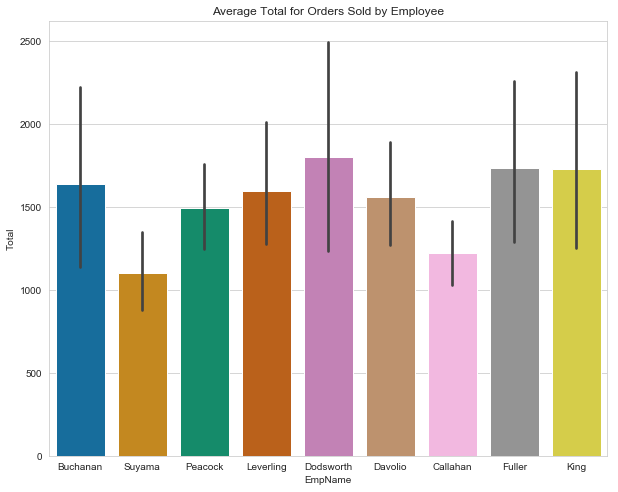

In [115]:
fig=plt.figure(figsize=[10,8])
sns.barplot(x='EmpName', y='Total', data=employees, palette='colorblind')
plt.title('Average Total for Orders Sold by Employee')
plt.show()

In [367]:
# dod = emp_df.loc[emp_df.EmpName == 'Dodsworth']
# suy = emp_df.loc[emp_df.EmpName == 'Suyama']
# fig=plt.figure(figsize=[12,8])
# #sns.lineplot(x='OrderDate', y='Total', data=dod, color='purple')
# sns.lineplot(x='OrderDate', y='Total', data=suy, color='gold')
# plt.show()

In [374]:
emp_df.isna().sum()

Order         0
OrderDate     0
EmpName       0
EmpId         0
BirthDay      0
Hired         0
Title         0
Quantity      0
Total         0
Discount      0
Freight       0
CustomerId    0
dtype: int64

In [116]:
employees.BirthDay = pd.to_datetime(employees.BirthDay)
employees.Hired = pd.to_datetime(employees.Hired)
age =  dt.datetime.now() - employees.BirthDay
#years = dt.datetime(2030, 4, 5) - emp_df.Hired
employees['Age'] = round(((age / np.timedelta64(1, 'D')).astype(int)) / 365, 2)
#emp_df['Tenure'] = round(((years / np.timedelta64(1, 'D')).astype(int)) / 365, 2)
employees.head()

,Order,OrderDate,EmpName,EmpId,BirthDay,Hired,Title,Quantity,Total,Discount,Freight,CustomerId,Age
0,10248,2012-07-04,Buchanan,5,1987-03-04,2025-10-17,Sales Manager,27,440.00,0.00,32.38,VINET,32.11
1,10249,2012-07-05,Suyama,6,1995-07-02,2025-10-17,Sales Representative,49,1863.40,0.00,11.61,TOMSP,23.77
2,10250,2012-07-08,Peacock,4,1969-09-19,2025-05-03,Sales Representative,60,1552.60,0.15,65.83,HANAR,49.57
3,10251,2012-07-08,Leverling,3,1995-08-30,2024-04-01,Sales Representative,41,654.06,0.05,41.34,VICTE,23.61
4,10252,2012-07-09,Peacock,4,1969-09-19,2025-05-03,Sales Representative,105,3597.90,0.05,51.30,SUPRD,49.57


In [172]:

# for name in employees.EmpName.unique():
#     distribution = employees.loc[employees.EmpName == name]
#     norm_check(distribution.Total, name)

In [117]:
employee_combos = list(itertools.combinations(employees.EmpName.unique(), 2))

In [118]:
columns = ['Employee1', 'Employee2', 'KS_p', 'MWU_p', 'KW_p', 'Effect_Size']
stats_output(employee_combos, employees, 'EmpName', 'Total', columns)

,Employee1,Employee2,KS_p,MWU_p,KW_p,Effect_Size
0,Buchanan,Suyama,0.418665,0.098185,0.195294,--
1,Buchanan,Peacock,0.989629,0.390665,0.780165,--
2,Buchanan,Leverling,0.532147,0.272963,0.544717,--
3,Buchanan,Dodsworth,0.795933,0.387565,0.771766,--
4,Buchanan,Davolio,0.985335,0.499254,1.000000,--
5,Buchanan,Callahan,0.696315,0.170784,0.340471,--
6,Buchanan,Fuller,0.997564,0.429303,0.856789,--
7,Buchanan,King,0.806616,0.303628,0.605204,--
8,Suyama,Peacock,0.208035,0.074472,0.148626,--
9,Suyama,Leverling,0.032309,0.196596,0.392447,-0.278116


### Do older employees sell more than younger employees?

In [176]:
employees.Age.describe()

count    830.000000
mean      33.311482
std        9.436014
min       21.190000
25%       23.770000
50%       32.100000
75%       38.340000
max       49.570000
Name: Age, dtype: float64

In [119]:
age_class = []

for age in employees.Age:
    if age <= 28:
        classification = 'Young'
    elif age > 28 and age <= 36:
        classification = 'Middle'
    else:
        classification = 'Relatively Old'
    age_class.append(classification)
    
employees['Age_Classification'] = age_class
employees.head()

,Order,OrderDate,EmpName,EmpId,BirthDay,Hired,Title,Quantity,Total,Discount,Freight,CustomerId,Age,Age_Classification
0,10248,2012-07-04,Buchanan,5,1987-03-04,2025-10-17,Sales Manager,27,440.00,0.00,32.38,VINET,32.11,Middle
1,10249,2012-07-05,Suyama,6,1995-07-02,2025-10-17,Sales Representative,49,1863.40,0.00,11.61,TOMSP,23.77,Young
2,10250,2012-07-08,Peacock,4,1969-09-19,2025-05-03,Sales Representative,60,1552.60,0.15,65.83,HANAR,49.57,Relatively Old
3,10251,2012-07-08,Leverling,3,1995-08-30,2024-04-01,Sales Representative,41,654.06,0.05,41.34,VICTE,23.61,Young
4,10252,2012-07-09,Peacock,4,1969-09-19,2025-05-03,Sales Representative,105,3597.90,0.05,51.30,SUPRD,49.57,Relatively Old


In [196]:
employees.Age_Classification.value_counts()

Young             309
Relatively Old    279
Middle            242
Name: Age_Classification, dtype: int64

In [120]:
age_combos = list(itertools.combinations(employees.Age_Classification.unique(), 2))

In [199]:
# for age in employees.Age_Classification.unique():
#     samp = employees.loc[employees.Age_Classification == age]
#     norm_check(samp.Total, age)

In [204]:
def variance_check_multiple(combos, df, grouper, target, normal, cols):
    store_values = []
    for combo in combos:
        samp1 = df.loc[df[grouper] == combo[0]]
        samp2 = df.loc[df[grouper] == combo[1]]
        v = variance_check(samp1[target], samp2[target], normal)
        store_values.append([combo[0], combo[1], v])
    
    return pd.DataFrame(store_values, columns=cols)


In [122]:
columns = ['Age_Class1', 'Age_Class2', 'Variance_Test_p', 'Result']
variance_check_multiple(age_combos, employees, 'Age_Classification', 'Total', 'no', columns)

,Age_Class1,Age_Class2,Variance_Test_p,Result
0,Middle,Young,0.218516,EQUAL variance
1,Middle,Relatively Old,0.192518,EQUAL variance
2,Young,Relatively Old,0.007907,UNEQUAL variance


In [123]:
columns = ['Age_Class1', 'Age_Class2', 'Kolmogorov-Smirnov_p', 'Mann_WhitneyU_p', 'KW_p', 'Effect_Size']
stats_output(age_combos, employees, 'Age_Classification', 'Total', columns)

,Age_Class1,Age_Class2,Kolmogorov-Smirnov_p,Mann_WhitneyU_p,KW_p,Effect_Size
0,Middle,Young,0.472558,0.306610,0.613031,--
1,Middle,Relatively Old,0.409130,0.229950,0.459723,--
2,Young,Relatively Old,0.216564,0.098156,0.196227,--


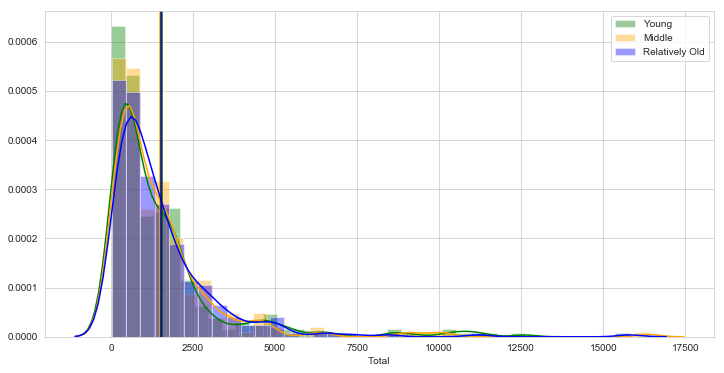

In [202]:
young_employees = employees.loc[employees.Age_Classification == 'Young']
middle_employees = employees.loc[employees.Age_Classification == 'Middle']
relatively_old_employees = employees.loc[employees.Age_Classification == 'Relatively Old']


fig = plt.figure(figsize=[12,6])
sns.distplot(young_employees.Total, color='green', label='Young')
plt.axvline(young_employees.Total.mean(), color='darkgreen')
sns.distplot(middle_employees.Total, color='orange', label='Middle')
plt.axvline(middle_employees.Total.mean(), color='orange')
sns.distplot(relatively_old_employees.Total, color='blue', label='Relatively Old')
plt.axvline(relatively_old_employees.Total.mean(), color='darkblue')
plt.legend()
plt.show()

### Do employees that give more discounts make more sales?

In [124]:
discounts = []

for value in employees.Discount:
    if value == 0:
        dis = 'No'
    else:
        dis = 'Yes'
    discounts.append(dis)

employees['Discount_Given'] = discounts
employees.head()

,Order,OrderDate,EmpName,EmpId,BirthDay,Hired,Title,Quantity,Total,Discount,Freight,CustomerId,Age,Age_Classification,Discount_Given
0,10248,2012-07-04,Buchanan,5,1987-03-04,2025-10-17,Sales Manager,27,440.00,0.00,32.38,VINET,32.11,Middle,No
1,10249,2012-07-05,Suyama,6,1995-07-02,2025-10-17,Sales Representative,49,1863.40,0.00,11.61,TOMSP,23.77,Young,No
2,10250,2012-07-08,Peacock,4,1969-09-19,2025-05-03,Sales Representative,60,1552.60,0.15,65.83,HANAR,49.57,Relatively Old,Yes
3,10251,2012-07-08,Leverling,3,1995-08-30,2024-04-01,Sales Representative,41,654.06,0.05,41.34,VICTE,23.61,Young,Yes
4,10252,2012-07-09,Peacock,4,1969-09-19,2025-05-03,Sales Representative,105,3597.90,0.05,51.30,SUPRD,49.57,Relatively Old,Yes


In [211]:
employees.groupby('Discount_Given')['EmpName'].count()

Discount_Given
No     466
Yes    364
Name: EmpName, dtype: int64

In [125]:
no_discount = employees.loc[employees.Discount == 0]
yes_discount = employees.loc[employees.Discount > 0]

In [126]:
discount_counts = []

for employee in employees.EmpName.unique():
    sample = yes_discount.loc[yes_discount.EmpName == employee]
    sample2 = employees.loc[employees.EmpName == employee]
    num_discounts = len(sample)
    num_sales = len(sample2)
    percent_discounted = round((num_discounts / num_sales) * 100, 2)
    discount_counts.append([employee, num_sales, num_discounts, percent_discounted])

discount_per_employee = pd.DataFrame(discount_counts, columns=
                                     ['Employee', 'Number_of_Sales', 'Number_Sales_with_Discount', 'Percentage_Discounted'])
discount_per_employee
    

,Employee,Number_of_Sales,Number_Sales_with_Discount,Percentage_Discounted
0,Buchanan,42,23,54.76
1,Suyama,67,30,44.78
2,Peacock,156,71,45.51
3,Leverling,127,49,38.58
4,Dodsworth,43,21,48.84
5,Davolio,123,54,43.90
6,Callahan,104,48,46.15
7,Fuller,96,33,34.38
8,King,72,35,48.61


In [232]:
discount_per_employee.describe()

,Number_of_Sales,Number_Sales_with_Discount,Percentage_Discounted
count,9.000000,9.000000,9.000000
mean,92.222222,40.444444,45.056667
std,39.318500,16.295023,5.914476
min,42.000000,21.000000,34.380000
25%,67.000000,30.000000,43.900000
50%,96.000000,35.000000,45.510000
75%,123.000000,49.000000,48.610000
max,156.000000,71.000000,54.760000


In [127]:
few_discounts = employees.loc[(employees.EmpName == 'Fuller') |
                             (employees.EmpName == 'Leverling') | 
                             (employees.EmpName == 'Davolio') | 
                             (employees.EmpName == 'Suyama') | 
                             (employees.EmpName == 'Peacock')]

more_discounts = employees.loc[(employees.EmpName == 'Callahan') | 
                              (employees.EmpName == 'King') | 
                              (employees.EmpName == 'Dodsworth') | 
                              (employees.EmpName == 'Buchanan')]

In [244]:
few_discounts.EmpName.unique()

array(['Suyama', 'Peacock', 'Leverling', 'Davolio', 'Fuller'],
      dtype=object)

In [245]:
more_discounts.EmpName.unique()

array(['Buchanan', 'Dodsworth', 'Callahan', 'King'], dtype=object)

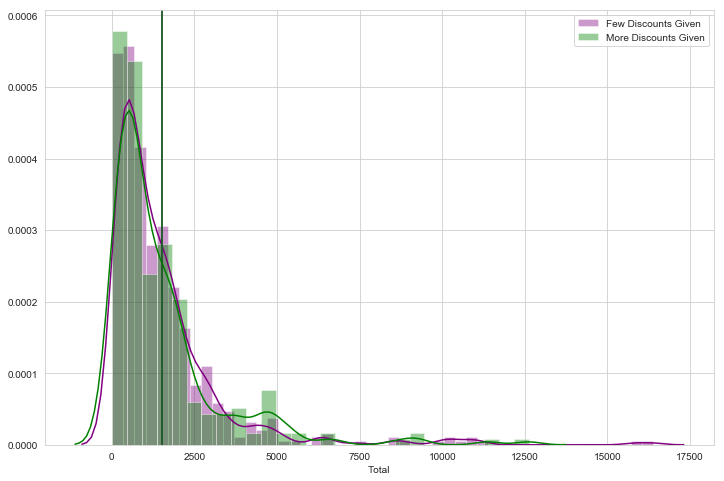

In [128]:
fig = plt.figure(figsize=[12,8])
sns.distplot(few_discounts.Total, color='purple', label='Few Discounts Given')
plt.axvline(few_discounts.Total.mean(), color='darkorchid')
sns.distplot(more_discounts.Total, color='green', label='More Discounts Given')
plt.axvline(more_discounts.Total.mean(), color='darkgreen')
plt.legend()
plt.show()

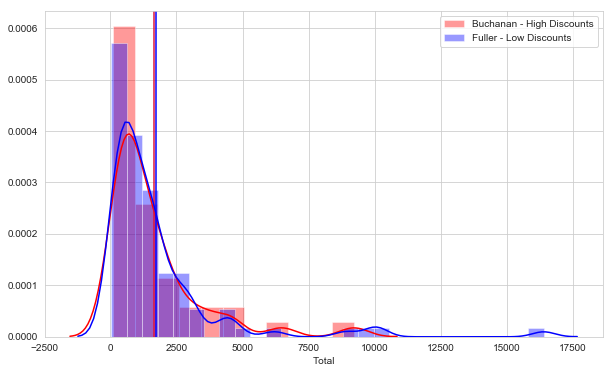

In [129]:
buchanan = employees.loc[employees.EmpName == 'Buchanan']
fuller = employees.loc[employees.EmpName == 'Fuller']

fig = plt.figure(figsize=[10,6])
sns.distplot(buchanan.Total, color='red', label='Buchanan - High Discounts')
plt.axvline(buchanan.Total.mean(), color='crimson')
sns.distplot(fuller.Total, color='blue', label='Fuller - Low Discounts')
plt.axvline(fuller.Total.mean(), color='blue')
plt.legend()
plt.show()

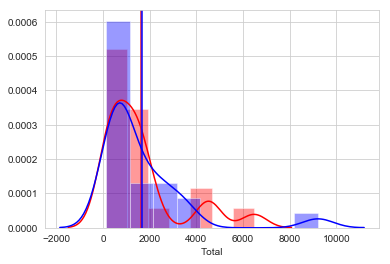

In [130]:
nd_buchanan = no_discount.loc[no_discount.EmpName == 'Buchanan']
yesd_buchanan = yes_discount.loc[yes_discount.EmpName == 'Buchanan']

sns.distplot(nd_buchanan.Total, color='red', label='No Discount')
plt.axvline(nd_buchanan.Total.mean(), color='crimson')
sns.distplot(yesd_buchanan.Total, color='blue', label='Discounts')
plt.axvline(yesd_buchanan.Total.mean(), color='blue')
plt.show()

In [258]:
nd_fuller = no_discount.loc[no_discount.EmpName == 'Fuller']
yesd_fuller = yes_discount.loc[yes_discount.EmpName == 'Fuller']

t=non_parametric(nd_fuller.Total, yesd_fuller.Total)
t[0][0]

ks = stats.ks_2samp(series1, series2)
    mwu = stats.mannwhitneyu(series1, series2)
    kw = stats.kruskal(series1, series2)
# sns.distplot(nd_fuller.Total, color='red', label='No Discount')
# plt.axvline(nd_fuller.Total.mean(), color='crimson')
# sns.distplot(yesd_fuller.Total, color='blue', label='Discounts')
# plt.axvline(yesd_fuller.Total.mean(), color='blue')
# plt.show()

0.006347438623815532

In [133]:
def employee_compare(name):
    no_disc = no_discount.loc[no_discount.EmpName == name]
    yes_disc = yes_discount.loc[yes_discount.EmpName == name]
    
    np_result = non_parametric(no_disc.Total, yes_disc.Total)
    print(name)
    print(f"Kolmogorov-Smirnov p-value: {np_result[0][0]}")
    print(f"Mann_WhitneyU p-value: {np_result[0][1]}")
    print(f"KW p-value: {np_result[0][2]}")
    print(f"Effect Size: {np_result[0][3]}")
    
    fig = plt.figure(figsize=[10,6])
    sns.distplot(no_disc.Total, color='purple', label='No Discount')
    plt.axvline(no_disc.Total.mean(), color='darkorchid')
    sns.distplot(yes_disc.Total, color='green', label='Discounts')
    plt.axvline(yes_disc.Total.mean(), color='darkgreen')
    plt.title(name)
    plt.legend()
    plt.show()

Buchanan
Kolmogorov-Smirnov p-value: 0.9074327889692138
Mann_WhitneyU p-value: 0.43974189228371163
KW p-value: 0.8695272985205063
Effect Size: --


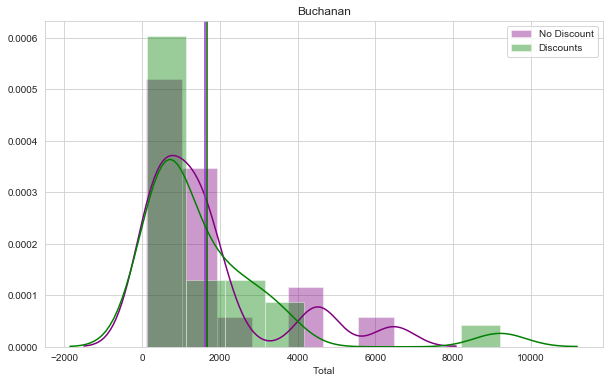

Suyama
Kolmogorov-Smirnov p-value: 0.5291423343581874
Mann_WhitneyU p-value: 0.12431002380463368
KW p-value: 0.24604389571845794
Effect Size: --


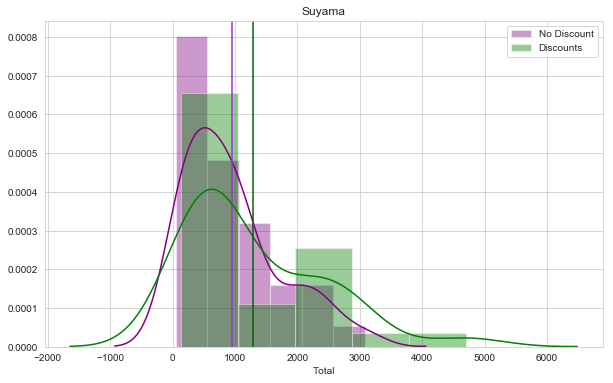

Peacock
Kolmogorov-Smirnov p-value: 0.001766122031040597
Mann_WhitneyU p-value: 0.0002469324888548783
KW p-value: 0.0004905916851573195
Effect Size: -0.47611897580382295


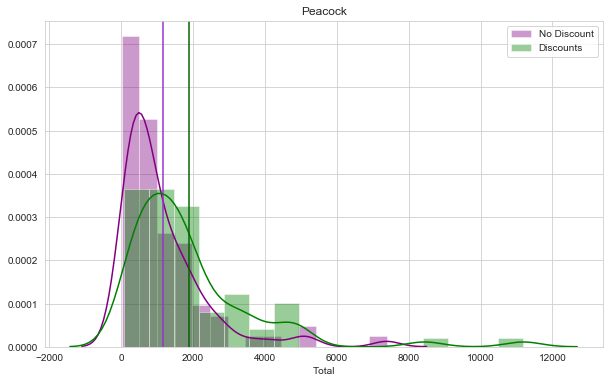

Leverling
Kolmogorov-Smirnov p-value: 0.0763963385516411
Mann_WhitneyU p-value: 0.052136540074130225
KW p-value: 0.10374604603754903
Effect Size: --


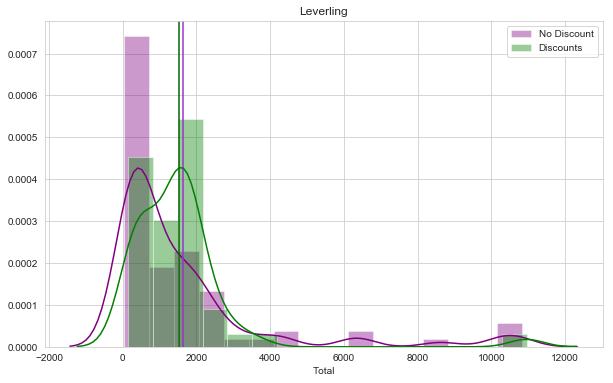

Dodsworth
Kolmogorov-Smirnov p-value: 0.22275647902891743
Mann_WhitneyU p-value: 0.1811166358381699
KW p-value: 0.3558685451916669
Effect Size: --


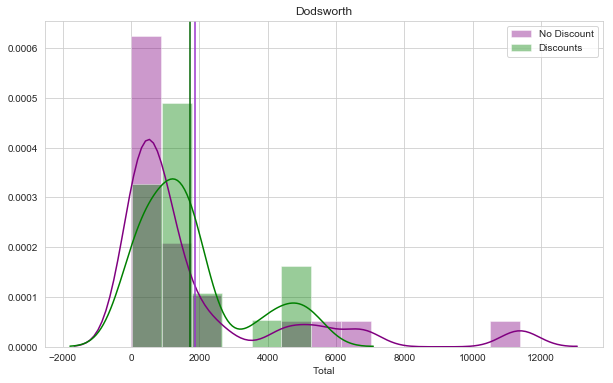

Davolio
Kolmogorov-Smirnov p-value: 0.8130653567900793
Mann_WhitneyU p-value: 0.4766322072132264
KW p-value: 0.9512349116685275
Effect Size: --


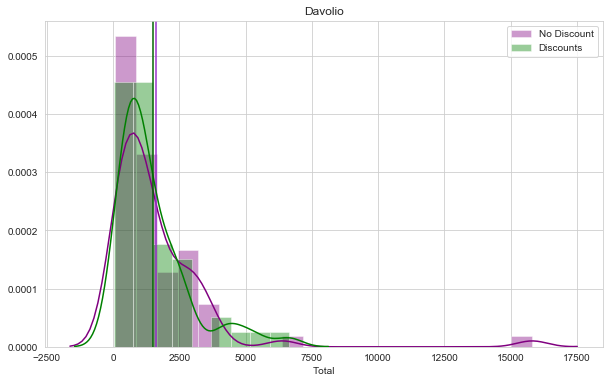

Callahan
Kolmogorov-Smirnov p-value: 0.5809598804296628
Mann_WhitneyU p-value: 0.34420595438745166
KW p-value: 0.6860131458138695
Effect Size: --


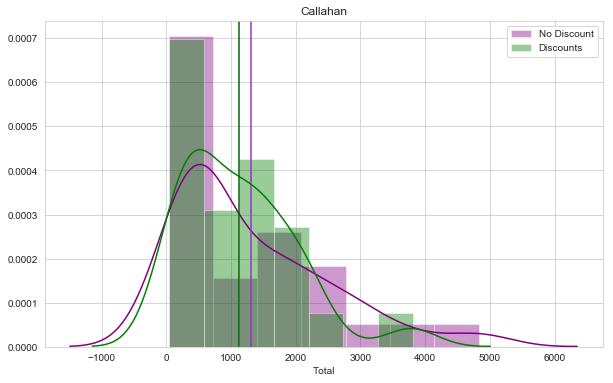

Fuller
Kolmogorov-Smirnov p-value: 0.006347438623815532
Mann_WhitneyU p-value: 0.0004676648109364381
KW p-value: 0.0009225254436569678
Effect Size: -0.501920528788615


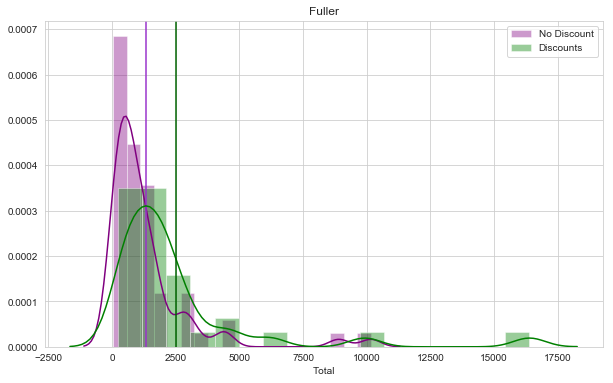

King
Kolmogorov-Smirnov p-value: 0.19617213189698818
Mann_WhitneyU p-value: 0.033144688987629796
KW p-value: 0.06546122900173672
Effect Size: -0.4747086183310023


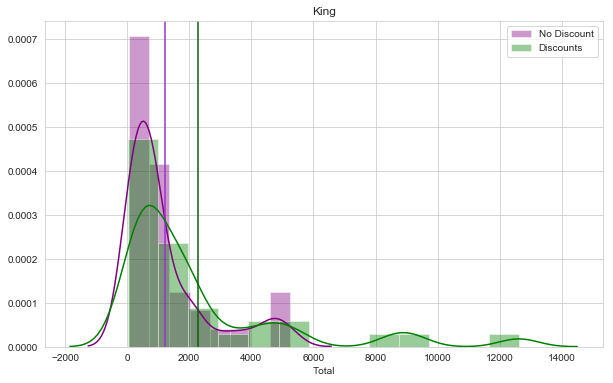

In [134]:
for employee in employees.EmpName.unique():
    employee_compare(employee)

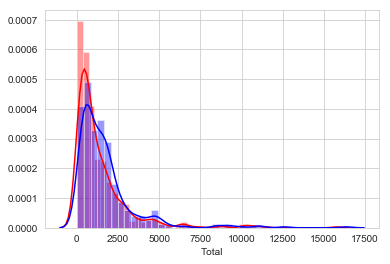

In [208]:
sns.distplot(no_discount.Total, color='red', label='No Discount')
sns.distplot(yes_discount.Total, color='blue', label='Discounted')
plt.show()

In [105]:
# formula = 'Total ~ Age + Tenure + C(EmpName)'
# lm = ols(formula, emp_df).fit()
# table = sm.stats.anova_lm(lm, typ=2)
# print(table)

                  sum_sq     df         F    PR(>F)
C(EmpName)  1.122947e+08    8.0  4.132182  0.000075
Age         6.787392e+06    1.0  1.998081  0.157878
Tenure      3.866203e+06    1.0  1.138138  0.286360
Residual    2.788901e+09  821.0       NaN       NaN


In [169]:
employees.groupby('EmpName')['CustomerId'].count()


EmpName
Buchanan      42
Callahan     104
Davolio      123
Dodsworth     43
Fuller        96
King          72
Leverling    127
Peacock      156
Suyama        67
Name: CustomerId, dtype: int64

In [388]:
emp_df.EmpName.unique()

array(['Buchanan', 'Suyama', 'Peacock', 'Leverling', 'Dodsworth',
       'Davolio', 'Callahan', 'Fuller', 'King'], dtype=object)

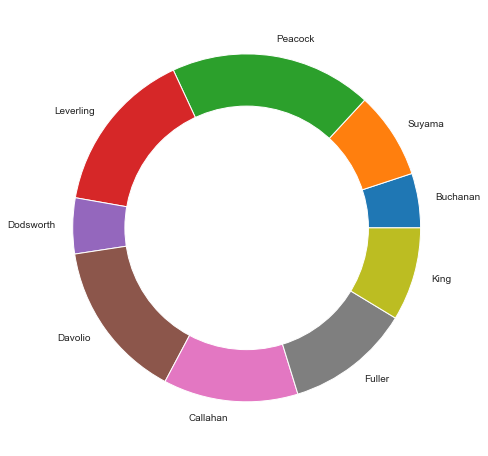

In [170]:


emp = employees.EmpName.unique()
acc = [42, 67, 156, 127, 43, 123, 104, 96, 72]

fig=plt.figure(figsize=[8,8])
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(acc, labels=emp)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()



### <font color='purple'>Is there an affect on order quantity from discount? If so, at what level of discount?</font>

In [136]:
# df_odetail = pd.read_sql_query('SELECT * from OrderDetail', engine)
# print(df_odetail.shape)
# df_odetail.OrderId.nunique()
# df_odetail.head(10)

In [135]:
order_detail = make_df('OrderDetail', cols=None)
order_detail.head()

2019-04-04 13:46:36,790 INFO sqlalchemy.engine.base.Engine SELECT * FROM OrderDetail
2019-04-04 13:46:36,790 INFO sqlalchemy.engine.base.Engine ()


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [137]:
order_detail['Unit_Total'] = order_detail.UnitPrice * order_detail.Quantity * (1 - order_detail.Discount)
order_detail.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Unit_Total
0,10248/11,10248,11,14.0,12,0.0,168.0
1,10248/42,10248,42,9.8,10,0.0,98.0
2,10248/72,10248,72,34.8,5,0.0,174.0
3,10249/14,10249,14,18.6,9,0.0,167.4
4,10249/51,10249,51,42.4,40,0.0,1696.0


In [138]:
order_totals = []
for num in order_detail.OrderId.unique():
    temp = order_detail.loc[order_detail.OrderId == num]
    order_totals.append([num, sum(temp.Quantity), sum(temp.Unit_Total), temp.Discount.unique(), temp.Discount.median()])

len(order_totals)



830

In [139]:
order_tot = pd.DataFrame(order_totals, columns=['OrderId', 'Total_Quantity', 'Order_Total', 'Discounts', 'Discount_Median'])
order_tot.head()


,OrderId,Total_Quantity,Order_Total,Discounts,Discount_Median
0,10248,27,440.00,[0.0],0.00
1,10249,49,1863.40,[0.0],0.00
2,10250,60,1552.60,"[0.0, 0.15]",0.15
3,10251,41,654.06,"[0.05, 0.0]",0.05
4,10252,105,3597.90,"[0.05, 0.0]",0.05


In [119]:
order_tot.Discount_Median.value_counts()

0.000    466
0.050     79
0.100     73
0.150     59
0.200     58
0.250     52
0.125     17
0.075     13
0.025     12
0.010      1
Name: Discount_Median, dtype: int64

In [140]:
#test1.loc[(test1.ShipRegion == 'Central America') | (test1.ShipRegion == 'South America'), 'ShipRegion'] = 
#'Central/South America'

order_discount = order_tot.copy()

order_discount.loc[(order_discount.Discount_Median > 0.001) & 
                   (order_discount.Discount_Median <= 0.05), 'Discount_Median'] = 0.05

order_discount.loc[(order_discount.Discount_Median > 0.051) & 
                   (order_discount.Discount_Median <= 0.10), 'Discount_Median'] = 0.10

order_discount.loc[(order_discount.Discount_Median > 0.101) & 
                   (order_discount.Discount_Median <= 0.15), 'Discount_Median'] = 0.15

order_discount.loc[(order_discount.Discount_Median > 0.151) & 
                   (order_discount.Discount_Median <= 0.20), 'Discount_Median'] = 0.20

order_discount.loc[(order_discount.Discount_Median > 0.201) & 
                   (order_discount.Discount_Median <= 0.25), 'Discount_Median'] = 0.25

order_discount.Discount_Median.value_counts()

0.00    466
0.05     92
0.10     86
0.15     76
0.20     58
0.25     52
Name: Discount_Median, dtype: int64

In [144]:
zero = order_discount.loc[order_discount.Discount_Median == 0]
five = order_discount.loc[order_discount.Discount_Median == 0.05]
ten = order_discount.loc[order_discount.Discount_Median == 0.10]
fifteen = order_discount.loc[order_discount.Discount_Median == 0.15]
twenty = order_discount.loc[order_discount.Discount_Median == 0.20]
twenty_five = order_discount.loc[order_discount.Discount_Median == 0.25]

no_discount = zero
yes_discount = order_discount.loc[order_discount.Discount_Median > 0]

Normality Check for 0.0: 
    Kolmogorov-Smirnov: 9.033329639862586e-10
    Shapiro-Wilks: 2.699364887599095e-22
Variance: 2315.8026858645994


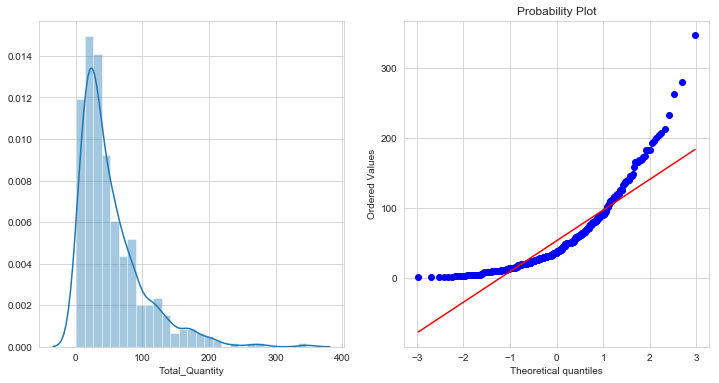

Normality Check for 0.15: 
    Kolmogorov-Smirnov: 0.020357405649398252
    Shapiro-Wilks: 3.5982549206892145e-07
Variance: 3338.825789473685


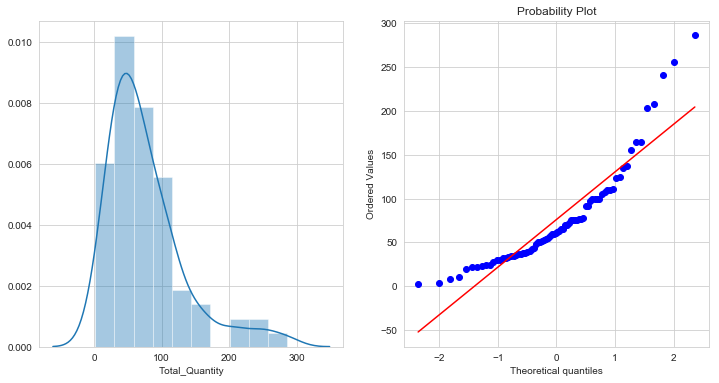

Normality Check for 0.05: 
    Kolmogorov-Smirnov: 0.007497994994779988
    Shapiro-Wilks: 2.767040996332071e-07
Variance: 2151.981366459627


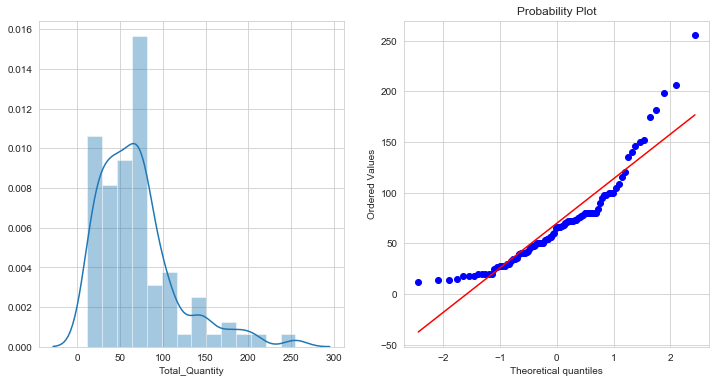

Normality Check for 0.2: 
    Kolmogorov-Smirnov: 0.19599241323998462
    Shapiro-Wilks: 4.094493851880543e-05
Variance: 2598.2894736842104


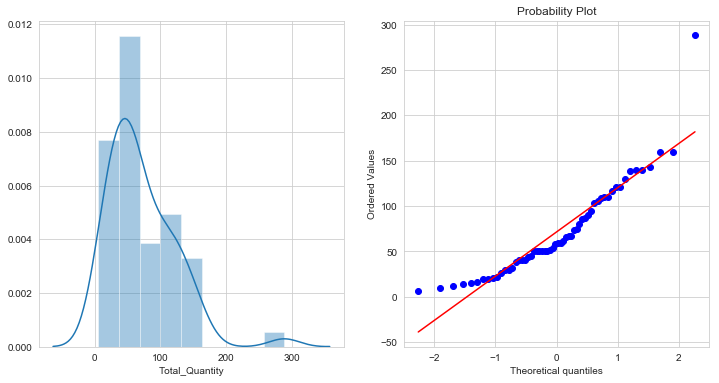

Normality Check for 0.25: 
    Kolmogorov-Smirnov: 0.3072312469489962
    Shapiro-Wilks: 7.018655742285773e-05
Variance: 3835.0377073906493


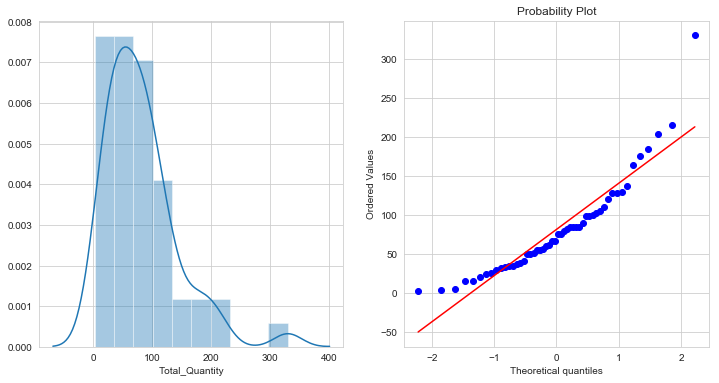

Normality Check for 0.1: 
    Kolmogorov-Smirnov: 0.15971162140496697
    Shapiro-Wilks: 2.584132232641423e-07
Variance: 2136.746511627907


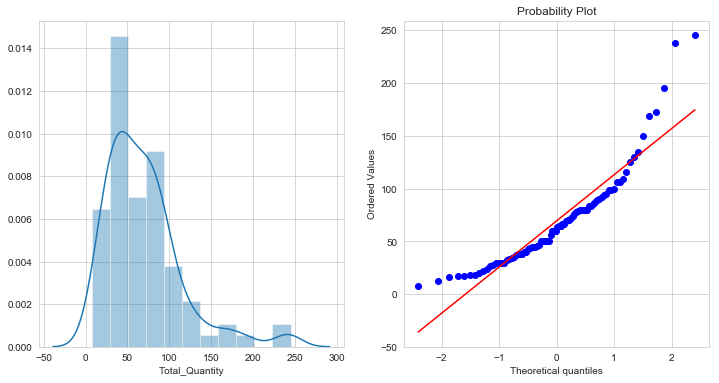

In [142]:
for discount in order_discount.Discount_Median.unique():
    sample = order_discount.loc[order_discount.Discount_Median == discount]
    norm_check(sample.Total_Quantity, discount)


# norm_check(zero.Total_Quantity, 'No Discount')
# norm_check(yesD.Total_Quantity, 'Discount Present')
# norm_check(five.Total_Quantity, '5% Discount')
# norm_check(ten.Total_Quantity, '10% Discount')
# norm_check(fifteen.Total_Quantity, '15% Discount')
# norm_check(twenty.Total_Quantity, '20% Discount')
# norm_check(twenty_five.Total_Quantity, '25% Discount')


In [193]:
variance_check(zero.Total_Quantity, yesD.Total_Quantity, 'no')

BartlettResult(statistic=2.353411795952561, pvalue=0.1250091431687837)

In [194]:
variance_check(zero.Order_Total, yesD.Order_Total, 'no')

BartlettResult(statistic=1.9242587032070082, pvalue=0.1653879427185237)

In [164]:
def ks_test_2(sample1, sample2, name):
    results = stats.ks_2samp(sample1, sample2)
    return print(f"KS P-value for {name}: {results[1]}")

ks_test_2(zero.Total_Quantity, yesD.Total_Quantity, 'Any Discount')
ks_test_2(zero.Total_Quantity, five.Total_Quantity, '5% Discount')
ks_test_2(zero.Total_Quantity, ten.Total_Quantity, '10% Discount')
ks_test_2(zero.Total_Quantity, fifteen.Total_Quantity, '15% Discount')
ks_test_2(zero.Total_Quantity, twenty.Total_Quantity, '20% Discount')
ks_test_2(zero.Total_Quantity, twenty_five.Total_Quantity, '25% Discount')

KS P-value for Any Discount: 3.2039180575165874e-12
KS P-value for 5% Discount: 3.580413321619543e-05
KS P-value for 10% Discount: 4.454363465206309e-05
KS P-value for 15% Discount: 0.00021278632546391094
KS P-value for 20% Discount: 0.0010806823097304025
KS P-value for 25% Discount: 0.0007449215953995661


In [218]:
print(f"Effect size for Discounts: {cohen_d(yesD.Total_Quantity, zero.Total_Quantity)}")
print(f"Effect Size of 5% Discounts: {cohen_d(five.Total_Quantity, zero.Total_Quantity)}")
print(f"Effect Size of 10% Discounts: {cohen_d(ten.Total_Quantity, zero.Total_Quantity)}")
print(f"Effect Size of 15% Discounts: {cohen_d(fifteen.Total_Quantity, zero.Total_Quantity)}")
print(f"Effect Size of 20% Discounts: {cohen_d(twenty.Total_Quantity, zero.Total_Quantity)}")
print(f"Effect Size of 25% Discounts: {cohen_d(twenty_five.Total_Quantity, zero.Total_Quantity)}")

Effect size for Discounts: 0.39676338180277326
Effect Size of 5% Discounts: 0.34338842022049726
Effect Size of 10% Discounts: 0.34115078614413763
Effect Size of 15% Discounts: 0.46298102762141874
Effect Size of 20% Discounts: 0.3785861637101337
Effect Size of 25% Discounts: 0.5696766119806607


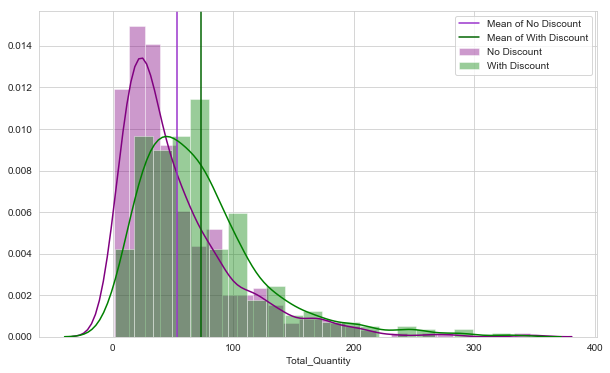

In [188]:
fig = plt.figure(figsize=[10,6])
sns.distplot(zero.Total_Quantity, color='purple', label='No Discount')
plt.axvline(x=zero.Total_Quantity.mean(), color='darkorchid', label='Mean of No Discount')
sns.distplot(yesD.Total_Quantity, color='green', label='With Discount')
plt.axvline(x=yesD.Total_Quantity.mean(), color='darkgreen', label='Mean of With Discount')
plt.legend()
plt.show()

## KS test summary for the affect of discount on order quantity:
The presence of a discount and all levels of discounts significantly affect the quantity of an order. As displayed by the graph above, the distribution for order with a discount is shifted to the right of the distribution for orders without a discount, indicating the quantites of orders with a discount is higher than orders without a discount.

In [169]:
ks_test_2(zero.Order_Total, yesD.Order_Total, 'Any Discount')
ks_test_2(zero.Order_Total, five.Order_Total, '5% Discount')
ks_test_2(zero.Order_Total, ten.Order_Total, '10% Discount')
ks_test_2(zero.Order_Total, fifteen.Order_Total, '15% Discount')
ks_test_2(zero.Order_Total, twenty.Order_Total, '20% Discount')
ks_test_2(zero.Order_Total, twenty_five.Order_Total, '25% Discount')

KS P-value for Any Discount: 7.02616259275359e-05
KS P-value for 5% Discount: 0.0015798934595452074
KS P-value for 10% Discount: 0.04756449657182428
KS P-value for 15% Discount: 0.022750545745933777
KS P-value for 20% Discount: 0.20336994259457603
KS P-value for 25% Discount: 0.054864274542870316


In [214]:

print(f"Effect Size of Discounts: {cohen_d(yesD.Order_Total, zero.Order_Total)}")
print(f"Effect Size of 5% Discounts: {cohen_d(five.Order_Total, zero.Order_Total)}")
print(f"Effect Size of 10% Discounts: {cohen_d(ten.Order_Total, zero.Order_Total)}")
print(f"Effect Size of 15% Discounts: {cohen_d(fifteen.Order_Total, zero.Order_Total)}")

Effect Size of Discounts: 0.16942164587506295
Effect Size of 5% Discounts: 0.3051140349479449
Effect Size of 10% Discounts: -0.019245548272695215
Effect Size of 15% Discounts: 0.22650591114191587


In [177]:
# Perform KS test to determine if the significant discounts affect quantity and total (respective) differently

print('ORDER QUANTITY')
ks_test_2(five.Total_Quantity, ten.Total_Quantity, '5% v 10% Discount')
ks_test_2(five.Total_Quantity, fifteen.Total_Quantity, '5% v 15% Discount')
ks_test_2(ten.Total_Quantity, fifteen.Total_Quantity, '10% v 15% Discount')
print('ORDER TOTAL')
ks_test_2(five.Order_Total, ten.Order_Total, '5% v 10% Discount')
ks_test_2(five.Order_Total, fifteen.Order_Total, '5% v 15% Discount')
ks_test_2(ten.Order_Total, fifteen.Order_Total, '10% v 15% Discount')

ORDER QUANTITY
KS P-value for 5% v 10% Discount: 0.9996829671822476
KS P-value for 5% v 15% Discount: 0.7946718038723347
KS P-value for 10% v 15% Discount: 0.6496183848180479
ORDER TOTAL
KS P-value for 5% v 10% Discount: 0.20409754105291944
KS P-value for 5% v 15% Discount: 0.5891948742851374
KS P-value for 10% v 15% Discount: 0.9267216154871694


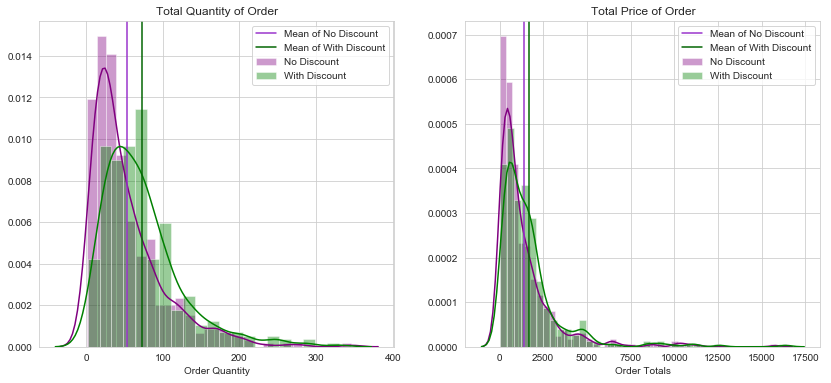

In [151]:
fig, axes = plt.subplots(1,2, figsize=[14,6])

sns.distplot(no_discount.Total_Quantity, color='purple', label='No Discount', ax=axes[0])
axes[0].axvline(x=no_discount.Total_Quantity.mean(), color='darkorchid', label='Mean of No Discount')
sns.distplot(yes_discount.Total_Quantity, color='green', label='With Discount', ax=axes[0])
axes[0].axvline(x=yes_discount.Total_Quantity.mean(), color='darkgreen', label='Mean of With Discount')
axes[0].legend()
axes[0].set_title('Total Quantity of Order')
axes[0].set_xlabel('Order Quantity')

sns.distplot(no_discount.Order_Total, color='purple', label='No Discount', ax=axes[1])
axes[1].axvline(x=no_discount.Order_Total.mean(), color='darkorchid', label='Mean of No Discount')
sns.distplot(yes_discount.Order_Total, color='green', label='With Discount', ax=axes[1])
axes[1].axvline(x=yes_discount.Order_Total.mean(), color='darkgreen', label='Mean of With Discount')
axes[1].set_title('Total Price of Order')
axes[1].set_xlabel('Order Totals')
axes[1].legend()
plt.show()

## KS test summary for affect of discount on total spent on an order:
The presence of a discount and discounts of 5%, 10%, and 15% significantly affect the total spent on an order. The graph above displays the distributions of the orders totals for orders with and without discounts. While similar, the distribution of the order totals with a discount is shifted slightly to the right of the distribution of order totals without a discount, thus the discounts increase the amount spent on an order. When KS tests were performed to assess the differences in effect of the three levels of discounts that were statistically significant (5%, 10%, 15%), no level proved to be statistically significant from the others. Therefore, applying a 15% discount on an order will not significantly increase the amount spent on an order from a 5% discount. Additionally, the effect size (cohen's d) of 5% discounts is larger than the effect size of 15% discounts, indicating that the 5% discounts affect the total spent on an order moreso than the 15% discounts.

In [165]:
def welch_t (sample1, sample2, name):
    results = stats.ttest_ind(sample1, sample2, equal_var=False)
    return print(f"Welsh T-test P-value for {name}: {results[1]}")

welch_t(zero.Total_Quantity, yesD.Total_Quantity, 'Any Discount')
welch_t(zero.Total_Quantity, five.Total_Quantity, '5% Discount')
welch_t(zero.Total_Quantity, ten.Total_Quantity, '10% Discount')
welch_t(zero.Total_Quantity, fifteen.Total_Quantity, '15% Discount')
welch_t(zero.Total_Quantity, twenty.Total_Quantity, '20% Discount')
welch_t(zero.Total_Quantity, twenty_five.Total_Quantity, '25% Discount')

Welsh T-test P-value for Any Discount: 2.7006893435671122e-08
Welsh T-test P-value for 5% Discount: 0.0024792854739129405
Welsh T-test P-value for 10% Discount: 0.0033937733871395683
Welsh T-test P-value for 15% Discount: 0.001448068978500822
Welsh T-test P-value for 20% Discount: 0.011359322835743242
Welsh T-test P-value for 25% Discount: 0.0022950563287111587


In [219]:
# mc = MultiComparison(otest.Total_Quantity, otest.Discount_Median)
# result = mc.tukeyhsd()

# print(result)
# print(mc.groupsunique)

In [220]:
# mc = MultiComparison(otest.Order_Total, otest.Discount_Median)
# result = mc.tukeyhsd()

# print(result)
# print(mc.groupsunique)

In [116]:
# hsd = order_tot.copy()
# hsd['No_Discount'] = np.where((hsd.Discount_Median == 0.0), 1, 0)
# hsd['Five_Percent'] = np.where((hsd.Discount_Median > 0.0) & (hsd.Discount_Median <= 0.05), 1, 0)
# hsd['Ten_Percent'] = np.where((hsd.Discount_Median > 0.05) & (hsd.Discount_Median <= 0.10), 1, 0)
# hsd['Fifteen_Percent'] = np.where((hsd.Discount_Median > 0.10) & (hsd.Discount_Median <= 0.15), 1, 0)
# hsd['Twenty_Percent'] = np.where((hsd.Discount_Median > 0.15) & (hsd.Discount_Median <= 0.20), 1, 0)
# hsd['Twenty_Five_Percent'] = np.where(hsd.Discount_Median == 0.25, 1, 0)

In [221]:
# hsd.head()

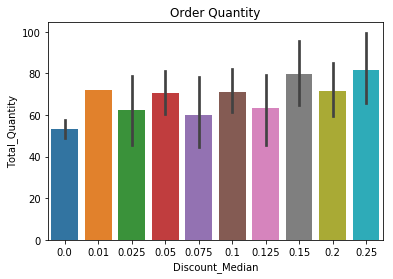

In [100]:
sns.barplot(x='Discount_Median', y='Total_Quantity', data=order_tot)
plt.title('Order Quantity')
plt.show()

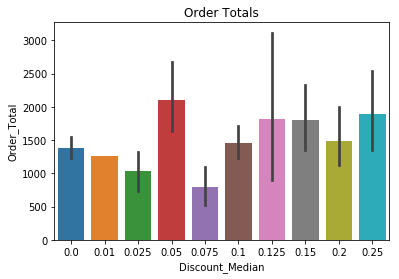

In [35]:
sns.barplot(x='Discount_Median', y='Order_Total', data=order_tot)
plt.title('Order Totals')
plt.show()

In [36]:
g2 = order_tot.groupby('Discount_Median')['Total_Quantity', 'Order_Total'].agg(['mean', 'std', 'count'])
g2

Total_Quantity                   Order_Total               \
                          mean        std count         mean          std   
Discount_Median                                                             
0.000                53.158798  48.122788   466  1388.353235  1783.223570   
0.010                72.000000        NaN     1  1255.720500          NaN   
0.025                62.666667  30.496895    12  1032.547083   553.701769   
0.050                70.607595  48.692762    79  2102.262196  2299.114906   
0.075                59.846154  33.490910    13   794.893000   535.821830   
0.100                71.191781  48.123584    73  1455.806781  1043.438672   
0.125                63.294118  37.396131    17  1813.243824  2553.892165   
0.150                79.813559  62.205853    59  1802.680975  2048.815330   
0.200                71.500000  50.973419    58  1493.295414  1709.400602   
0.250                81.461538  61.927681    52  1897.951394  2315.359272   

                       
                count  
Discount_Median        
0.000             466  
0.010               1  
0.025              12  
0.050              79  
0.075              13  
0.100              73  
0.125              17  
0.150              59  
0.200              58  
0.250              52

In [122]:
# zero = order_tot.loc[order_tot['Discount_Median'] == 0]
# five = order_tot.loc[order_tot['Discount_Median'] == 0.05]
# ten = order_tot.loc[order_tot['Discount_Median'] == 0.1]
# fifteen = order_tot.loc[order_tot['Discount_Median'] == 0.15]
# twenty = order_tot.loc[order_tot['Discount_Median'] == 0.2]
# twenty_five = order_tot.loc[order_tot['Discount_Median'] == 0.25]

In [23]:
def norm_check(series, name):
    ks_result = stats.kstest(series, 'norm', args=(series.mean(), series.std()))
    sw_result = stats.shapiro(series)
    print(f"Normality Check for {name}: KS - [{ks_result[1]}], Shapiro-Wilks - [{sw_result[1]}]")
    print(f"Variance: {series.var()}")
    fig, axes = plt.subplots(1,2, figsize=[12,6])
    sns.distplot(series, ax=axes[0])
    plt.title(name)
    stats.probplot(series, plot=axes[1])
    plt.show()

In [18]:
def variance_check(series1, series2, norm):
    if norm == 'yes':
        res = stats.levene(series1, series2)
        return res[1]
    else:
        res = stats.bartlett(series1, series2)
        return res[1]

In [19]:
def ks_test_2(sample1, sample2, name):
    results = stats.ks_2samp(sample1, sample2)
    return print(f"P-value for {name}: {results[1]}")

In [20]:
def cohen_d(group1, group2):

    # Compute Cohen's d.

    # group1: Series or NumPy array
    # group2: Series or NumPy array

    # returns a floating point number 

    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [21]:
def non_parametric(series1, series2, name):
    np = []
    ks = stats.ks_2samp(series1, series2)
    mwu = stats.mannwhitneyu(series1, series2)
    kw = stats.kruskal(series1, series2)
    
    if ks[1]<0.05 or mwu[1]<0.05 or kw[1]<0.05:
        d = cohen_d(series1, series2)
    else:
        d = '--'
    
    np.append([ks[1], mwu[1], kw[1], d])
    
    return np

In [111]:
t = non_parametric(ctype_o.Total, ctype_m.Total, 'Owners v Management')

In [123]:
outs = []
for combo in combos:
    samp1 = ship3.loc[ship3.ShipRegion == combo[0]]
    samp2 = ship3.loc[ship3.ShipRegion == combo[1]]
    nps = non_parametric(samp1.Freight, samp2.Freight, name=None)
    outs.append([combo[0], combo[1], nps[0][0], nps[0][1], nps[0][2], nps[0][3]])

out_df = pd.DataFrame(outs, columns=['Region1', 'Region2', 'KS_p', 'MWU_p', 'KW_p', 'EffectSize'])
out_df

,Region1,Region2,KS_p,MWU_p,KW_p,EffectSize
0,Western Europe,North America,0.711463,0.420628,0.839456,--
1,Western Europe,Northern Europe/Scandinavia,0.027325,0.006521,0.012898,0.479495
2,Western Europe,Eastern/Southern Europe,0.003280,0.000183,0.000360,0.611474
3,Western Europe,Central/South America,0.002812,0.000416,0.000824,0.563215
4,Western Europe,British Isles,0.071795,0.020994,0.041620,0.409868
5,North America,Northern Europe/Scandinavia,0.037944,0.020187,0.039877,0.536532
6,North America,Eastern/Southern Europe,0.006480,0.001195,0.002347,0.673981
7,North America,Central/South America,0.011809,0.002765,0.005474,0.639351
8,North America,British Isles,0.165215,0.053880,0.106726,--
9,Northern Europe/Scandinavia,Eastern/Southern Europe,0.444281,0.131505,0.258491,--


In [141]:
ship3_results = []
for combo in combos:
    first = combo[0]
    second = combo[1]
    samp1 = ship3.loc[ship3.ShipRegion == first]
    samp2 = ship3.loc[ship3.ShipRegion == second]
    p = ks_test2_revised(samp1.Freight, samp2.Freight)
    if p >= 0.05:
        r = 'not significant'
        d = '--'
    elif p < 0.05:
        r = 'SIGNIFICANT'
        d = cohen_d(samp1.Freight, samp2.Freight)
    ship3_results.append([first, second, p, r, d])
    
s3_region = pd.DataFrame(ship3_results, columns=['Region1', 'Region2', 'KS_p_val', 'Outcome', 'Effect_Size'])
s3_region

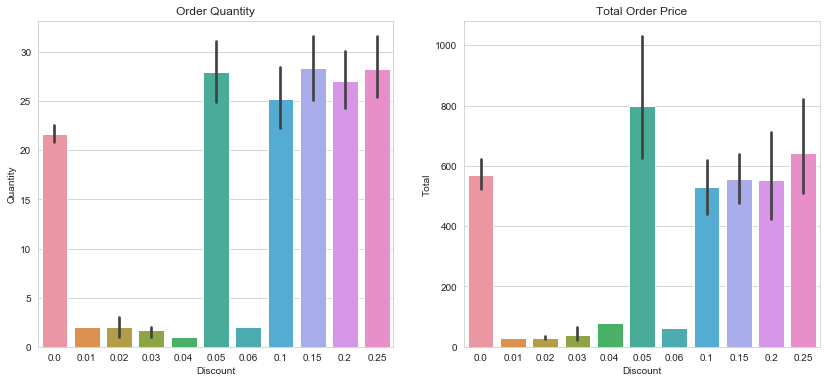

In [96]:
fig, axes = plt.subplots(1,2, figsize=[14,6])

df_odetail['Total'] = df_odetail.UnitPrice * df_odetail.Quantity * (1-df_odetail.Discount)
sns.barplot(x='Discount', y='Total', data=df_odetail, ax=axes[1])
axes[1].set_title('Total Order Price')
sns.barplot(x='Discount', y='Quantity', data=df_odetail, ax=axes[0])
axes[0].set_title('Order Quantity')
plt.show()

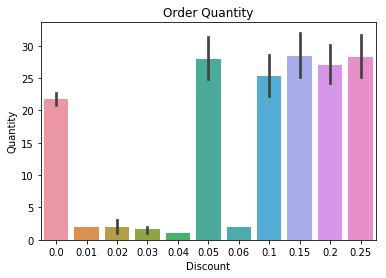

In [20]:

sns.barplot(x='Discount', y='Quantity', data=df_odetail)
plt.title('Order Quantity')
plt.show()

### Possible values for hue in Seaborn ### 
Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, icefire, icefire_r, inferno, inferno_r, jet, jet_r, magma, magma_r, mako, mako_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, rocket, rocket_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, twilight, twilight_r, twilight_shifted, twilight_shifted_r, viridis, viridis_r, vlag, vlag_r, winter, winter_r